# Analysis file for Ariane quantitative runs
gets data from .nc file into basic plot<br>
based on code from https://github.com/SalishSeaCast/analysis-susan/blob/master/notebooks/Ariane/FluxRobertsBankApr2015-New.ipynb

In [1]:
import cmocean.cm as cm
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
from dateutil.relativedelta import relativedelta
import datetime as dt

import scipy.interpolate as interp
from scipy.stats import binned_statistic_2d

%matplotlib inline
# plt.rcParams['font.size'] = 18

### get grid info

In [2]:
mymesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask201702.nc')
depthf = interp.interp1d(mymesh.z, mymesh.gdept_1d)

# Functions

In [3]:
def draw_patches(fmask, lonW, lonE, t_dist, t_depths): #draw ground part of cross section
    topo = []
    for i in range(lonW,lonE):
        for j in range(39):
            if fmask[j, i] == 0:
                rect = Rectangle((t_dist[i], t_depths[j]), t_dist[i+1]-t_dist[i], t_depths[j+1]-t_depths[j])
                topo.append(rect)
    pc = PatchCollection(topo, facecolors='lightgray', zorder=3)
    return(pc)

In [4]:
#lets make a fun lil matrix with all of the info we need about every channel to run the cross-section code
#in the format [section, jgridW, jgridE, figrid, maxdepth]
admiralty = [2, 255, 267, 204, 100]
rosario = [4, 286, 307, 266, 100]
sanjuan = [5, 264, 266, 280, 100]
haro = [6, 218, 242, 304, 300]

#in the format [section, jgridS, jgridN, figrid, maxdepth]
decep = [3, 246, 247, 309, 20]

In [5]:
def JRFluxCS(lonW, lonE, figrid, maxdepth, salfile, ax, title):
    igrid = figrid-1
    fmask = mymesh.fmask[0, :, igrid]
    tmask = mymesh.tmask[0]
    nav_lon = mymesh.nav_lon[igrid]
    time = 720
    
    lons = mydata.init_lon[(mydata.final_section != 0)]
    lats = mydata.init_lat[(mydata.final_section != 0)]
    
    t_lons = mymesh.glamt[0, igrid]
    m2lon = ((t_lons[lonE]-t_lons[lonW])/(mymesh.e1t[0, igrid, lonW:lonE].sum()))
    t_dist = t_lons/m2lon
    t_depths = mymesh.gdept_1d[0,:]
    
    dist = lons/m2lon
    depths = depthf(mydata.init_z[(mydata.final_section != 0)]-1.)[0]
    transports = mydata.init_transp[(mydata.final_section != 0)]/time
    
    tick = 0.12
    vmax = tick/sum(transports)
#     vmax = .12/sum(transports)/m2lon
    
    H, xedges, yedges = np.histogram2d(dist, depths, bins=[np.array(t_dist[lonW-1:lonE]), t_depths],weights= transports, density= True)
    
    #maybe get rid of the lines? - the divide by numbers feel rather arbitrary but the best solution i can think of
    #not quatifying based on figs so i think fine
    h= H
    h[11,:] = H[11,:]/2.2
    h[19,:] = H[19,:]/2.3
    h[28,:] = H[28,:]/2
    h[36,:] = H[36,:]/2
    
#     h = np.where(h>0, h, h*np.nan)

    X, Y = np.meshgrid(xedges, yedges)
#     im = ax.pcolormesh(X, Y, h.T, vmax = vmax, vmin = 0, cmap=cm.speed)
    im = ax.pcolormesh(X, Y, h.T, vmax = vmax, vmin = 0, cmap=cm.speed)
    
    cb1 = fig.colorbar(im, ax=ax)
    cb1.set_ticks([0, vmax])
    cb1.set_ticklabels([0, tick]) 
    cb1.set_label('$m^3 \, s^{-1} m^{-2}$', labelpad=-20, fontsize=14)
    
    xs, ys = np.meshgrid(np.array(t_dist[lonW-1:lonE+1]), np.array(t_depths))
    salinity = 0.5*(np.ma.array(salfile.vosaline[0, :, igrid, lonW-1:lonE+1],
            mask=1-tmask[:, igrid, lonW-1:lonE+1]) +
            np.ma.array(salfile.vosaline[0, :, igrid+1, lonW-1:lonE+1],
            mask=1-tmask[:, igrid+1, lonW-1:lonE+1]))
    CS = ax.contour(xs, ys, salinity,  np.arange(29,35, 1), colors='b', zorder = 2)#, label= 'Mean salinity [$g \, kg^{-1}$]')
    ax.clabel(CS, inline=1, fontsize=12, fmt='%1.0f')
    
    pc = draw_patches(fmask, lonW-2, lonE, np.array(t_dist), np.array(t_depths))
    ax.add_collection(pc)

    ax.invert_yaxis()
    ax.set_xticks([t_dist[lonW+1], t_dist[lonE-3]])
    ax.set_ylabel('Depth [m]', fontsize=14)
    ax.set_xticklabels(['USA','Canada'], fontsize=12)
    ax.set_xlim((t_dist[lonW-2], t_dist[lonE]))
    ax.set_ylim((maxdepth, 0))
    ax.set_title(str(title), fontsize=16)
    mydata.close()

In [6]:
salJan18 = xr.open_dataset("/results2/SalishSea/nowcast-green.201905/15jan18/SalishSea_1d_20180115_20180115_grid_T.nc")
salMay18 = xr.open_dataset("/results2/SalishSea/nowcast-green.201905/15may18/SalishSea_1d_20180515_20180515_grid_T.nc")


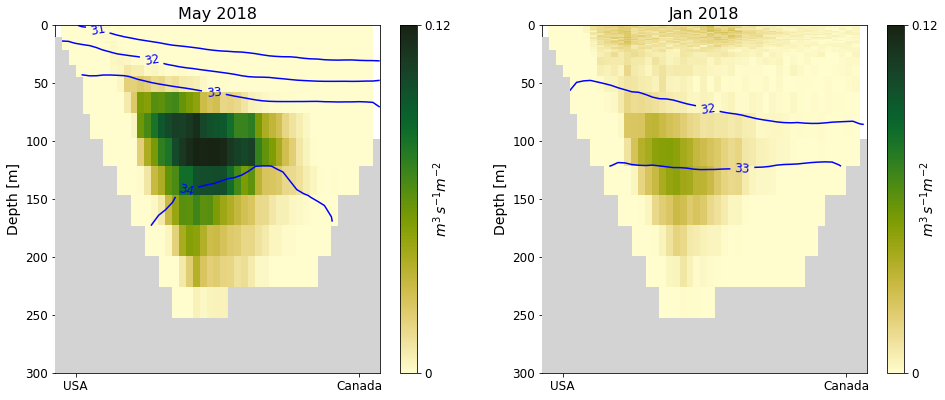

In [8]:
fig, ax = plt.subplots(1,2,figsize=(16,6.4))
plt.rcParams['font.size'] = 12


file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Car_Sal/forward_01may18/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
JRFluxCS(18, 63, 377, 300, salMay18, ax[0], "May 2018")

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Car_Sal/forward_01jan18/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
JRFluxCS(18, 63, 377, 300, salJan18, ax[1], "Jan 2018")
plt.savefig("./figures/CSfluxMayJan.pdf")

In [7]:
yearjumps = [0,1,-2,1,0,1,0,1,1,0,1,0]
oct_start = 1+(9*720+(sum(yearjumps[:10]*24)))
dec_end = 720+(11*720+(sum(yearjumps[:12]*24)))
jan_start = 1
mar_end = 720+(2*720+(sum(yearjumps[:3]*24)))
apr_start = 1+(3*720+(sum(yearjumps[:4]*24)))
sep_end = 720+(8*720+(sum(yearjumps[:9]*24)))

In [8]:
# get data for winter 2016/17

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan16/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)

time = (mar_end - jan_start + 1) + (dec_end - oct_start + 1) # need to deivide by the FULL timespan you're looking at

transport1 = mydata.init_transp[(mydata.final_section != 0) & (mydata.init_t >= oct_start) & (mydata.init_t <= dec_end)]/time
lon1 =  mydata['init_lon'][(mydata.final_section != 0) & (mydata.init_t >= oct_start) & (mydata.init_t <= dec_end)]
depth1 =  mydata['init_depth'][(mydata.final_section != 0) & (mydata.init_t >= oct_start) & (mydata.init_t <= dec_end)]

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan17/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)

transport2 = mydata.init_transp[(mydata.final_section != 0) & (mydata.init_t >= jan_start) & (mydata.init_t <= mar_end)]/time
lon2 =  mydata['init_lon'][(mydata.final_section != 0) & (mydata.init_t >= jan_start) & (mydata.init_t <= mar_end)]
depth2 =  mydata['init_depth'][(mydata.final_section != 0) & (mydata.init_t >= jan_start) & (mydata.init_t <= mar_end)]

tranW16 = np.append(transport1, transport2)
lonW16 = np.append(lon1,lon2)
depthW16 = np.append(depth1,depth2)

In [9]:
# get data for winter 2017/18

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan17/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)

transport1 = mydata.init_transp[(mydata.final_section != 0) & (mydata.init_t >= oct_start) & (mydata.init_t <= dec_end)]/time
lon1 =  mydata['init_lon'][(mydata.final_section != 0) & (mydata.init_t >= oct_start) & (mydata.init_t <= dec_end)]
depth1 =  mydata['init_depth'][(mydata.final_section != 0) & (mydata.init_t >= oct_start) & (mydata.init_t <= dec_end)]

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan17/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)

months = ['jan', 'feb', 'mar']
files = ['/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_1hr/forward_01'+month+'18/ariane_positions_quantitative.nc' for month in months]
transport2 = []
lon2 = []
depth2 = []

for file in files:
    mydata = xr.open_dataset(file)
    transport2 = np.append(transport2, mydata.init_transp[(mydata.final_section != 0)]/time)
    lon2 = np.append(lon2, mydata['init_lon'][(mydata.final_section != 0)])
    depth2 = np.append(depth2, mydata['init_depth'][(mydata.final_section != 0)])
    
tranW17 = np.append(transport1, transport2)
lonW17 = np.append(lon1, lon2)
depthW17 = np.append(depth1, depth2)

In [10]:
# get data for summer 2017

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan17/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)

time = sep_end - apr_start +1

# tempS17 = mydata['init_temp'][(mydata.final_section != 0) & (mydata.init_t >= apr_start) & (mydata.init_t <= sep_end)]
# saltS17 = mydata['init_salt'][(mydata.final_section != 0) & (mydata.init_t >= apr_start) & (mydata.init_t <= sep_end)]
tranS17 = mydata.init_transp[(mydata.final_section != 0) & (mydata.init_t >= apr_start) & (mydata.init_t <= sep_end)]/time
lonS17 = mydata['init_lon'][(mydata.final_section != 0) & (mydata.init_t >= apr_start) & (mydata.init_t <= sep_end)]
depthS17 = mydata['init_depth'][(mydata.final_section != 0) & (mydata.init_t >= apr_start) & (mydata.init_t <= sep_end)]

In [11]:
def JRFluxSeason(lonW, lonE, figrid, maxdepth, ax, lons, transports, depths):
    igrid = figrid-1
    fmask = mymesh.fmask[0, :, igrid]
    tmask = mymesh.tmask[0]
    nav_lon = mymesh.nav_lon[igrid]
    
    t_lons = mymesh.glamt[0, igrid]
    m2lon = ((t_lons[lonE]-t_lons[lonW])/(mymesh.e1t[0, igrid, lonW:lonE].sum()))
    t_dist = t_lons/m2lon
    t_depths = mymesh.gdept_1d[0,:]
    
    xs, ys = np.meshgrid(np.array(t_dist), np.array(t_depths))
    
    dist = lons/m2lon
    
    vmax = .25/sum(transports)
    
    H, xedges, yedges = np.histogram2d(dist, depths*-1, bins=[np.array(t_dist[lonW-1:lonE]), t_depths],weights= transports, density= True)

#     maybe get rid of the lines? - the divide by numbers feel rather arbitrary but the best solution i can think of
#     not quatifying based on figs so i think fine
    h= H
    h[11,:] = H[11,:]/2.2
    h[19,:] = H[19,:]/2.3
    h[28,:] = H[28,:]/2
    h[36,:] = H[36,:]/2

    X, Y = np.meshgrid(xedges, yedges)
    im = ax.pcolormesh(X, Y, h.T, vmax = vmax, vmin = 0, cmap=cm.speed)
#     im = ax.pcolormesh(X, Y, H.T, vmax = vmax, vmin = 0, cmap=cm.speed)
    
    cb1 = fig.colorbar(im, ax=ax)
    cb1.set_ticks([0, vmax])
    cb1.set_ticklabels([0, np.round(((vmax * sum(transports)).values),2)]) 
    cb1.set_label('m s$^{-1}$', labelpad=-20)
    
    pc = draw_patches(fmask, lonW-2, lonE, np.array(t_dist), np.array(t_depths))
    ax.add_collection(pc)

    ax.invert_yaxis()
    ax.set_xticks([t_dist[lonW+1], t_dist[lonE-1]])
    ax.set_ylabel('Depth [m]')
    ax.set_xticklabels(np.round([t_lons[lonW+1], t_lons[lonE-1]],2))
    ax.set_xlim((t_dist[lonW-2], t_dist[lonE]))
    ax.set_ylim((maxdepth, 0))
#     ax.set_title(str(title))

In [12]:
igrid = 377-1
fmask = mymesh.fmask[0, :, igrid]
tmask = mymesh.tmask[0]
nav_lon = mymesh.nav_lon[igrid]

In [13]:
lonW = 18
lonE=63

t_lons = mymesh.glamt[0, igrid]
m2lon = ((t_lons[lonE]-t_lons[lonW])/(mymesh.e1t[0, igrid, lonW:lonE].sum()))
t_dist = t_lons/m2lon
t_depths = mymesh.gdept_1d[0,:]

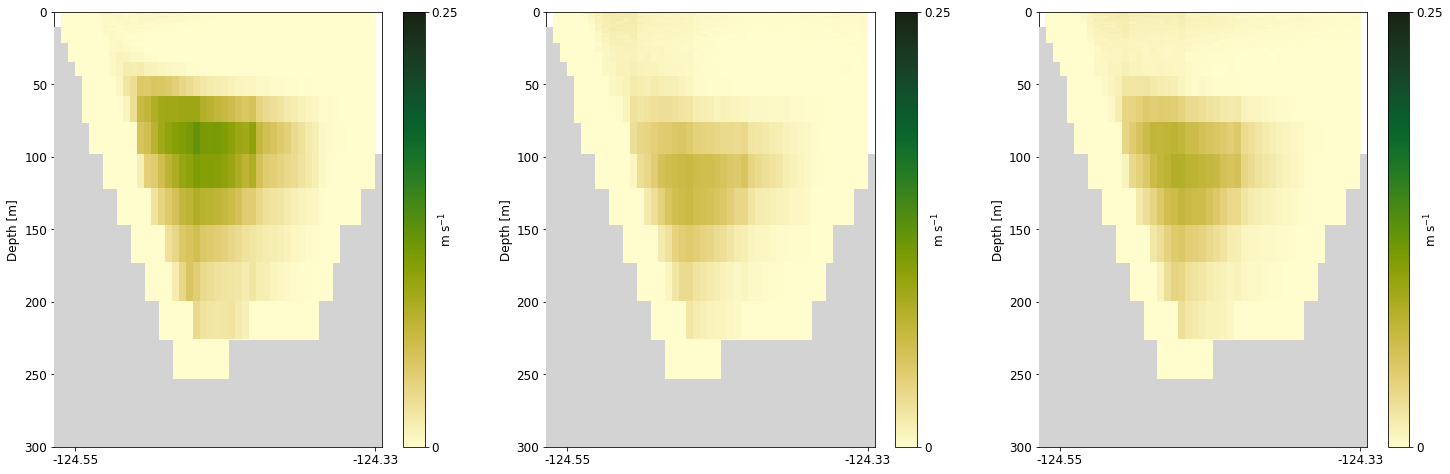

In [14]:
fig, ax = plt.subplots(1,3,figsize=(25,8))
plt.rcParams['font.size'] = 12

JRFluxSeason(18, 63, 377, 300, ax[0], lonS17, tranS17, depthS17)
JRFluxSeason(18, 63, 377, 300, ax[1], xr.DataArray(lonW16), xr.DataArray(tranW16), xr.DataArray(depthW16))
JRFluxSeason(18, 63, 377, 300, ax[2], xr.DataArray(lonW17), xr.DataArray(tranW17), xr.DataArray(depthW17))

### lets see how much gets deeper into the Salish - same plots again but includng meander this time

In [15]:
# get data for winter 2016/17
yearjumps = [0,1,-2,1,0,1,0,1,1,0,1,0]

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan16/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)

time = (mar_end - jan_start + 1) + (dec_end - oct_start + 1) # need to deivide by the FULL timespan you're looking at

transport1 = mydata.init_transp[(mydata.init_t >= oct_start) & (mydata.init_t <= dec_end)]/time
lon1 =  mydata['init_lon'][(mydata.init_t >= oct_start) & (mydata.init_t <= dec_end)]
depth1 =  mydata['init_depth'][(mydata.init_t >= oct_start) & (mydata.init_t <= dec_end)]

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan17/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)

transport2 = mydata.init_transp[(mydata.init_t >= jan_start) & (mydata.init_t <= mar_end)]/time
lon2 =  mydata['init_lon'][(mydata.init_t >= jan_start) & (mydata.init_t <= mar_end)]
depth2 =  mydata['init_depth'][(mydata.init_t >= jan_start) & (mydata.init_t <= mar_end)]

MtranW16 = np.append(transport1, transport2)
MlonW16 = np.append(lon1,lon2)
MdepthW16 = np.append(depth1,depth2)

In [16]:
# get data for winter 2017/18

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan17/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)

transport1 = mydata.init_transp[(mydata.init_t >= oct_start) & (mydata.init_t <= dec_end)]/time
lon1 =  mydata['init_lon'][(mydata.init_t >= oct_start) & (mydata.init_t <= dec_end)]
depth1 =  mydata['init_depth'][(mydata.init_t >= oct_start) & (mydata.init_t <= dec_end)]

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan17/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)

months = ['jan', 'feb', 'mar']
files = ['/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_1hr/forward_01'+month+'18/ariane_positions_quantitative.nc' for month in months]
transport2 = []
lon2 = []
depth2 = []

for file in files:
    mydata = xr.open_dataset(file)
    transport2 = np.append(transport2, mydata.init_transp/time)
    lon2 = np.append(lon2, mydata['init_lon'])
    depth2 = np.append(depth2, mydata['init_depth'])
    
MtranW17 = np.append(transport1, transport2)
MlonW17 = np.append(lon1, lon2)
MdepthW17 = np.append(depth1, depth2)

In [17]:
# get data for summer 2017

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan17/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)

apr_start = 1+(3*720+(sum(yearjumps[:4]*24)))
sep_end = 720+(8*720+(sum(yearjumps[:9]*24)))
time = sep_end - apr_start +1

# tempS17 = mydata['init_temp'][(mydata.init_t >= apr_start) & (mydata.init_t <= sep_end)]
# saltS17 = mydata['init_salt'][(mydata.init_t >= apr_start) & (mydata.init_t <= sep_end)]
MtranS17 = mydata.init_transp[(mydata.init_t >= apr_start) & (mydata.init_t <= sep_end)]/time
MlonS17 = mydata['init_lon'][(mydata.init_t >= apr_start) & (mydata.init_t <= sep_end)]
MdepthS17 = mydata['init_depth'][(mydata.init_t >= apr_start) & (mydata.init_t <= sep_end)]

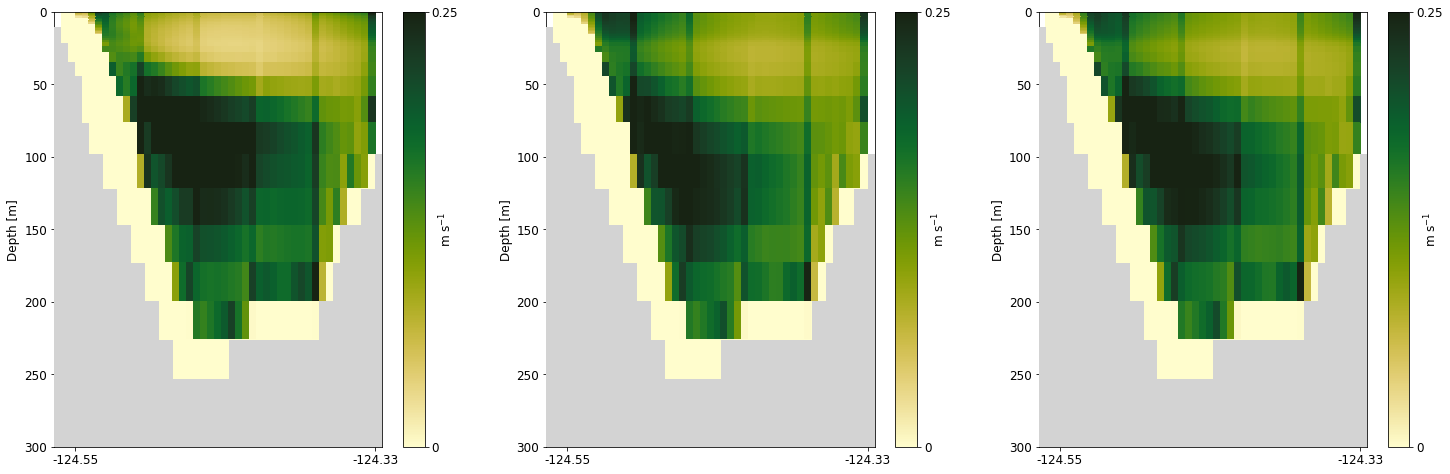

In [18]:
fig, ax = plt.subplots(1,3,figsize=(25,8))
plt.rcParams['font.size'] = 12

JRFluxSeason(18, 63, 377, 300, ax[0], MlonS17, MtranS17, MdepthS17)
JRFluxSeason(18, 63, 377, 300, ax[1], xr.DataArray(MlonW16), xr.DataArray(MtranW16), xr.DataArray(MdepthW16))
JRFluxSeason(18, 63, 377, 300, ax[2], xr.DataArray(MlonW17), xr.DataArray(MtranW17), xr.DataArray(MdepthW17))

In [19]:
# clearly most of the inflow is meander
print(f"percentage of flow that gets deeper in the winter of 2016/17 = {np.sum(tranW16)/np.sum(MtranW16)*100}")
print(f"percentage of flow that gets deeper in the summer of 2017 = {np.sum(tranS17)/np.sum(MtranS17)*100}")
print(f"percentage of flow that gets deeper in the winter of 2017/18 = {np.sum(tranW17)/np.sum(MtranW17)*100}")

percentage of flow that gets deeper in the winter of 2016/17 = 8.73136046790037
percentage of flow that gets deeper in the summer of 2017 = <xarray.DataArray 'init_transp' ()>
array(16.35887923)
percentage of flow that gets deeper in the winter of 2017/18 = 10.461871468414438


In [20]:
# DEPTH OF INFLOW MATTERS
# deep (>50 m)
print(f"deeper than 50 m inflow, percentage that gets inland in the winter of 2016/17 = {np.sum(np.where(depthW16 < -50, tranW16, 0))/np.sum(np.where(MdepthW16 < -50, MtranW16, 0))*100}")
print(f"deeper than 50 m inflow, percentage that gets inland in the summer of 2017 = {np.sum(np.where(depthS17 < -50, tranS17, 0))/np.sum(np.where(MdepthS17 < -50, MtranS17, 0))*100}")
print(f"deeper than 50 m inflow, percentage that gets inland in the winter of 2017/18 = {np.sum(np.where(depthW17 < -50, tranW17, 0))/np.sum(np.where(MdepthW17 < -50, MtranW17, 0))*100}")

deeper than 50 m inflow, percentage that gets inland in the winter of 2016/17 = 11.06888020422083
deeper than 50 m inflow, percentage that gets inland in the summer of 2017 = 20.007143160496526
deeper than 50 m inflow, percentage that gets inland in the winter of 2017/18 = 13.076415281105938


In [21]:
# shallow (<=50 m)
print(f"shallower than 50 m inflow, percentage that gets inland in the winter of 2016/17 = {np.sum(np.where(depthW16 >= -50, tranW16, 0))/np.sum(np.where(MdepthW16 >= -50, MtranW16, 0))*100}")
print(f"shallower than 50 m inflow, percentage that gets inland in the summer of 2017 = {np.sum(np.where(depthS17 >= -50, tranS17, 0))/np.sum(np.where(MdepthS17 >= -50, MtranS17, 0))*100}")
print(f"shallower than 50 m inflow, percentage that gets inland in the winter of 2017/18 = {np.sum(np.where(depthW17 >= -50, tranW17, 0))/np.sum(np.where(MdepthW17 >= -50, MtranW17, 0))*100}")

shallower than 50 m inflow, percentage that gets inland in the winter of 2016/17 = 2.729608146158204
shallower than 50 m inflow, percentage that gets inland in the summer of 2017 = 2.874192552028505
shallower than 50 m inflow, percentage that gets inland in the winter of 2017/18 = 3.3101790359382717


## i think useful to make a timeseries of percentage of inflow that goes inland over time for the CIOPS time-period i'm looking at

In [22]:
def get_data_all(mydata, starttime, endtime):
    depths = depthf(mydata.init_z[(mydata.init_t >= starttime) & (mydata.init_t <= endtime)]-1.)[0]
    transports = mydata.init_transp[(mydata.init_t >= starttime) & (mydata.init_t <= endtime)]/(endtime-starttime+1)
#     lons = mydata.init_lon[(mydata.init_t >= starttime) & (mydata.init_t <= endtime)]
    salt = mydata.init_salt[(mydata.init_t >= starttime) & (mydata.init_t <= endtime)]
    temp = mydata.init_temp[(mydata.init_t >= starttime) & (mydata.init_t <= endtime)]
    return depths, transports, salt, temp

def get_data_no_meander(mydata, starttime, endtime):
    depths = depthf(mydata.init_z[(mydata.final_section != 0) & (mydata.init_t >= starttime) & (mydata.init_t <= endtime)]-1.)[0]
    transports = mydata.init_transp[(mydata.final_section != 0) & (mydata.init_t >= starttime) & (mydata.init_t <= endtime)]/(endtime-starttime+1)
#     lons = mydata.init_lon[(mydata.final_section != 0) & (mydata.init_t >= starttime) & (mydata.init_t <= endtime)]
    salt = mydata.init_salt[(mydata.final_section != 0) & (mydata.init_t >= starttime) & (mydata.init_t <= endtime)]
    temp = mydata.init_temp[(mydata.final_section != 0) & (mydata.init_t >= starttime) & (mydata.init_t <= endtime)]
    return depths, transports, salt, temp

In [23]:
yearjumps = [0,1,-2,1,0,1,0,1,1,0,1,0]
str_mo = ['jan', 'feb', 'mar', 'apr','may', 'jun', 'jul', 'aug', 'sep','oct', 'nov', 'dec']
starttime = 1
endtime = 720

tranTOP = np.array([])
tranBOT = np.array([])
MtranTOP = np.array([])
MtranBOT = np.array([])

warm_fresh = np.array([])
warm_salt = np.array([]) 
cold_salt = np.array([])
Mwarm_fresh = np.array([])
Mwarm_salt = np.array([]) 
Mcold_salt = np.array([])

#2016 and 2017
year = [16,17]

for num in year:
    file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan'+str(num)+'/ariane_positions_quantitative.nc'
    mydata = xr.open_dataset(file)
    for i in range(12):
        tempD, tempT, tempS, tempTe= get_data_no_meander(mydata, starttime+(i*720+(sum(yearjumps[:i+1]*24))), endtime+(i*720+(sum(yearjumps[:i+1]*24))))
        MtempD, MtempT, MtempS, MtempTe= get_data_all(mydata, starttime+(i*720+(sum(yearjumps[:i+1]*24))), endtime+(i*720+(sum(yearjumps[:i+1]*24))))
                
        tranTOP = np.append(tranTOP, np.sum(np.where(tempD <= 50, tempT, 0)))
        tranBOT = np.append(tranBOT, np.sum(np.where(tempD > 50, tempT, 0)))
        MtranTOP = np.append(MtranTOP, np.sum(np.where(MtempD <= 50, MtempT, 0)))
        MtranBOT = np.append(MtranBOT, np.sum(np.where(MtempD > 50, MtempT, 0)))
        
        warm_fresh = np.append(warm_fresh, np.sum(np.where((tempS <= 31.8) & (tempTe >= 8.25), tempT, 0)))
        warm_salt = np.append(warm_salt, np.sum(np.where((tempS > 31.8) & (tempTe >= 8.25), tempT, 0))) 
        cold_salt = np.append(cold_salt, np.sum(np.where((tempS > 31.8) & (tempTe < 8.25), tempT, 0)))
        Mwarm_fresh = np.append(Mwarm_fresh, np.sum(np.where((MtempS <= 31.8) & (MtempTe >= 8.25), MtempT, 0)))
        Mwarm_salt = np.append(Mwarm_salt, np.sum(np.where((MtempS > 31.8) & (MtempTe >= 8.25), MtempT, 0))) 
        Mcold_salt = np.append(Mcold_salt, np.sum(np.where((MtempS > 31.8) & (MtempTe < 8.25), MtempT, 0)))

#2019 and 2018 (both done month by month)
year = [18,19]
for num in year:
    for i in range(len(str_mo)):
        file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_1hr/forward_01'+str_mo[i]+str(num)+'/ariane_positions_quantitative.nc'
        mydata = xr.open_dataset(file)
        time = mydata.init_t[-1]

        MtempD = depthf(mydata.init_z -1.)[0]
        MtempT = mydata.init_transp/time
        MtempS = mydata.init_salt
        MtempTe = mydata.init_temp
            
        tempD = depthf(mydata.init_z[(mydata.final_section != 0)]-1.)[0]
        tempT = mydata.init_transp[(mydata.final_section != 0)]/time
        tempS = mydata.init_salt[(mydata.final_section != 0)] 
        tempTe = mydata.init_temp[(mydata.final_section != 0)]
            
        tranTOP = np.append(tranTOP, np.sum(np.where(tempD <= 50, tempT, 0)))
        tranBOT = np.append(tranBOT, np.sum(np.where(tempD > 50, tempT, 0)))
        MtranTOP = np.append(MtranTOP, np.sum(np.where(MtempD <= 50, MtempT, 0)))
        MtranBOT = np.append(MtranBOT, np.sum(np.where(MtempD > 50, MtempT, 0)))
        
        warm_fresh = np.append(warm_fresh, np.sum(np.where((tempS <= 31.8) & (tempTe >= 8.25), tempT, 0)))
        warm_salt = np.append(warm_salt, np.sum(np.where((tempS > 31.8) & (tempTe >= 8.25), tempT, 0))) 
        cold_salt = np.append(cold_salt, np.sum(np.where((tempS > 31.8) & (tempTe < 8.25), tempT, 0)))
        Mwarm_fresh = np.append(Mwarm_fresh, np.sum(np.where((MtempS <= 31.8) & (MtempTe >= 8.25), MtempT, 0)))
        Mwarm_salt = np.append(Mwarm_salt, np.sum(np.where((MtempS > 31.8) & (MtempTe >= 8.25), MtempT, 0))) 
        Mcold_salt = np.append(Mcold_salt, np.sum(np.where((MtempS > 31.8) & (MtempTe < 8.25), MtempT, 0)))
            

#2020
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan20/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
for i in range(12):
    tempD, tempT, tempS, tempTe = get_data_no_meander(mydata, starttime+(i*720+(sum(yearjumps[:i+1]*24))), endtime+(i*720+(sum(yearjumps[:i+1]*24))))
    MtempD, MtempT, MtempS, MtempTe = get_data_all(mydata, starttime+(i*720+(sum(yearjumps[:i+1]*24))), endtime+(i*720+(sum(yearjumps[:i+1]*24))))
                
    tranTOP = np.append(tranTOP, np.sum(np.where(tempD <= 50, tempT, 0)))
    tranBOT = np.append(tranBOT, np.sum(np.where(tempD > 50, tempT, 0)))
    MtranTOP = np.append(MtranTOP, np.sum(np.where(MtempD <= 50, MtempT, 0)))
    MtranBOT = np.append(MtranBOT, np.sum(np.where(MtempD > 50, MtempT, 0)))
    
    warm_fresh = np.append(warm_fresh, np.sum(np.where((tempS <= 31.8) & (tempTe >= 8.25), tempT, 0)))
    warm_salt = np.append(warm_salt, np.sum(np.where((tempS > 31.8) & (tempTe >= 8.25), tempT, 0))) 
    cold_salt = np.append(cold_salt, np.sum(np.where((tempS > 31.8) & (tempTe < 8.25), tempT, 0)))
    Mwarm_fresh = np.append(Mwarm_fresh, np.sum(np.where((MtempS <= 31.8) & (MtempTe >= 8.25), MtempT, 0)))
    Mwarm_salt = np.append(Mwarm_salt, np.sum(np.where((MtempS > 31.8) & (MtempTe >= 8.25), MtempT, 0))) 
    Mcold_salt = np.append(Mcold_salt, np.sum(np.where((MtempS > 31.8) & (MtempTe < 8.25), MtempT, 0)))

In [107]:
dates = np.array([dt.datetime(2016,1,1)+relativedelta(months=i) for i in range(12*5)])

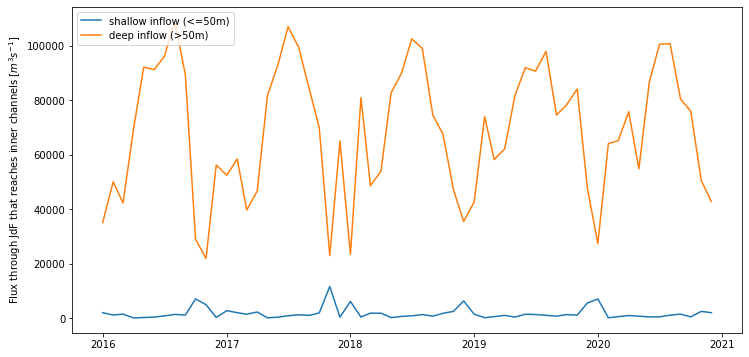

In [108]:
# first lets just look at how much is coming shallow versus at depth over the time-period
fig, ax = plt.subplots(1,1, figsize=[12,6])

ax.plot(dates,tranTOP,label='shallow inflow (<=50m)')
ax.plot(dates,tranBOT,label='deep inflow (>50m)')
ax.set_ylabel('Flux through JdF that reaches inner channels [$m^3 s^{-1}$]')
ax.legend();

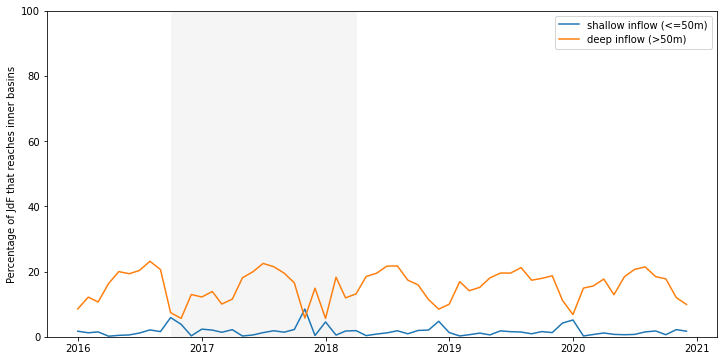

In [109]:
# first lets just look at how much is coming shallow versus at depth over the time-period
fig, ax = plt.subplots(1,1, figsize=[12,6])

ax.plot(dates,(tranTOP/MtranTOP)*100,label='shallow inflow (<=50m)')
ax.plot(dates,(tranBOT/MtranBOT)*100,label='deep inflow (>50m)')
ax.set_ylabel('Percentage of JdF that reaches inner basins')
ax.fill_between(dates, 0, 100, where=(dates<dates[27+1])&(dates>=dates[9]), color='whitesmoke')
ax.set_ylim([0,100])

ax.legend();

## but what if we differentiated based on temperature and salinity instead of depth alone?

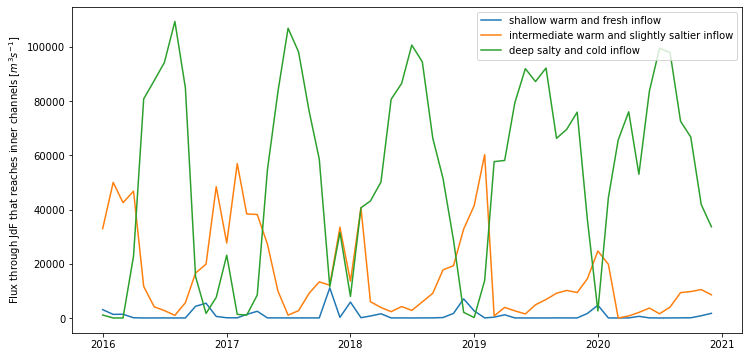

In [112]:
# first lets just look at how much is coming shallow versus at depth over the time-period
fig, ax = plt.subplots(1,1, figsize=[12,6])

ax.plot(dates,warm_fresh,label='shallow warm and fresh inflow')
ax.plot(dates,warm_salt,label='intermediate warm and slightly saltier inflow')
ax.plot(dates,cold_salt,label='deep salty and cold inflow')
ax.set_ylabel('Flux through JdF that reaches inner channels [$m^3 s^{-1}$]')
ax.legend();

<ipython-input-148-91f5ab60ba63>:6: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(dates,(cold_salt/Mcold_salt)*100,label='deep salty and cold inflow')


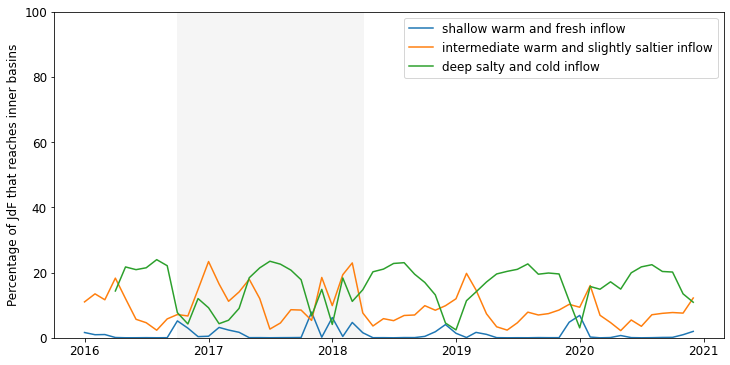

In [148]:
# first lets just look at how much is coming shallow versus at depth over the time-period
fig, ax = plt.subplots(1,1, figsize=[12,6])

ax.plot(dates,(warm_fresh/Mwarm_fresh)*100,label='shallow warm and fresh inflow')
ax.plot(dates,(warm_salt/Mwarm_salt)*100,label='intermediate warm and slightly saltier inflow')
ax.plot(dates,(cold_salt/Mcold_salt)*100,label='deep salty and cold inflow')
ax.set_ylabel('Percentage of JdF that reaches inner basins')
ax.fill_between(dates, 0, 100, where=(dates<dates[27+1])&(dates>=dates[9]), color='whitesmoke')
ax.set_ylim([0,100])
ax.legend();

In [24]:
print("DONE")

DONE


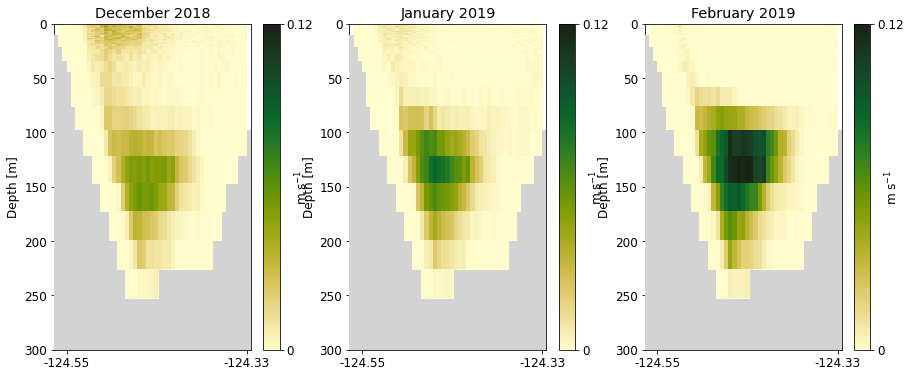

In [26]:
# lets see if those months with high intermediate inflow also look transient like we'd expect them to
fig, ax = plt.subplots(1,3,figsize=(15,6))

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Car_Sal/forward_01dec18/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
JRFluxCS(18, 63, 377, 300, ax[0], "December 2018")

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Car_Sal/forward_01jan19/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
JRFluxCS(18, 63, 377, 300, ax[1], "January 2019")

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Car_Sal/forward_01feb19/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
JRFluxCS(18, 63, 377, 300, ax[2], "February 2019")

In [114]:
def JRTracerFluxCS(tracername, lonW, lonE, figrid, maxdepth, ax, title):
    igrid = figrid-1
    fmask = mymesh.fmask[0, :, igrid]
    tmask = mymesh.tmask[0]
    nav_lon = mymesh.nav_lon[igrid]
    time = 720
    
    lons = mydata.init_lon[(mydata.final_section != 0)]
    lats = mydata.init_lat[(mydata.final_section != 0)]
    
    t_lons = mymesh.glamt[0, igrid]
    m2lon = ((t_lons[lonE]-t_lons[lonW])/(mymesh.e1t[0, igrid, lonW:lonE].sum()))
    t_dist = t_lons/m2lon
    t_depths = mymesh.gdept_1d[0,:]
    
    xs, ys = np.meshgrid(np.array(t_dist), np.array(t_depths))
    
    dist = lons/m2lon
    depths = depthf(mydata.init_z[(mydata.final_section != 0)]-1.)[0]
    transports = mydata.init_transp[(mydata.final_section != 0)]/time
    
    if tracername == 'salt' or tracername == 'silicon':
        tracer = mydata.init_salt[(mydata.final_section != 0)]
        if tracername == 'salt':
            t_max = round(34 * 0.1,1)
            cmap = cm.haline
        else:
            t_max = round(45 * 0.1,1)
            cmap = cm.matter
    elif tracername == 'temp' or tracername == 'nitrate' or tracername == 'carbon':
        tracer = mydata.init_temp[(mydata.final_section != 0)]
        if tracername == 'nitrate':
            t_max = round(30 * 0.1,1)
            cmap = cm.rain
        else:
            t_max = round(2200 * 0.1,1)
            cmap = cm.turbid
    else:
        print('incorrect tracer name, options are salt, temp, silicon, carbon, nitrate')

               
    H1, xedges1, yedges1 = np.histogram2d(dist, depths, bins=[np.array(t_dist[lonW-1:lonE]), t_depths],weights= transports, density= True)# vmax=vmax)

    H = binned_statistic_2d(dist, depths, tracer, statistic=np.mean, bins=[np.array(t_dist[lonW-1:lonE]), t_depths])
    _, xedges, yedges = np.histogram2d(dist, depths, bins = [np.array(t_dist[lonW-1:lonE]), t_depths])
       
    H_final = H1.T * H.statistic.T * float(sum(transports))
    np.nan_to_num(H_final, nan=0, copy=False)
    

    X, Y = np.meshgrid(xedges, yedges)
#     cmap.set_bad('grey', None)
    im = ax.pcolormesh(X, Y, H_final, vmax = t_max, vmin = 0, cmap=cmap)
    cb1 = fig.colorbar(im, ax=ax)
    cb1.set_ticks([0, t_max])
    cb1.set_ticklabels([0, t_max]) 
    cb1.set_label('g kg-1 m s-1', labelpad=-20)
    
    pc = draw_patches(fmask, lonW-2, lonE, np.array(t_dist), np.array(t_depths))
    ax.add_collection(pc)

    ax.invert_yaxis()
    ax.set_xticks(np.linspace(t_dist[lonW+1], t_dist[lonE-1], 5))
    ax.set_xticklabels(np.round(np.linspace(t_lons[lonW+1], t_lons[lonE-1], 5),2))
    ax.set_xlim((t_dist[lonW-2], t_dist[lonE]))
    ax.set_ylim((maxdepth, 0))
    ax.set_title(str(title))
    mydata.close()

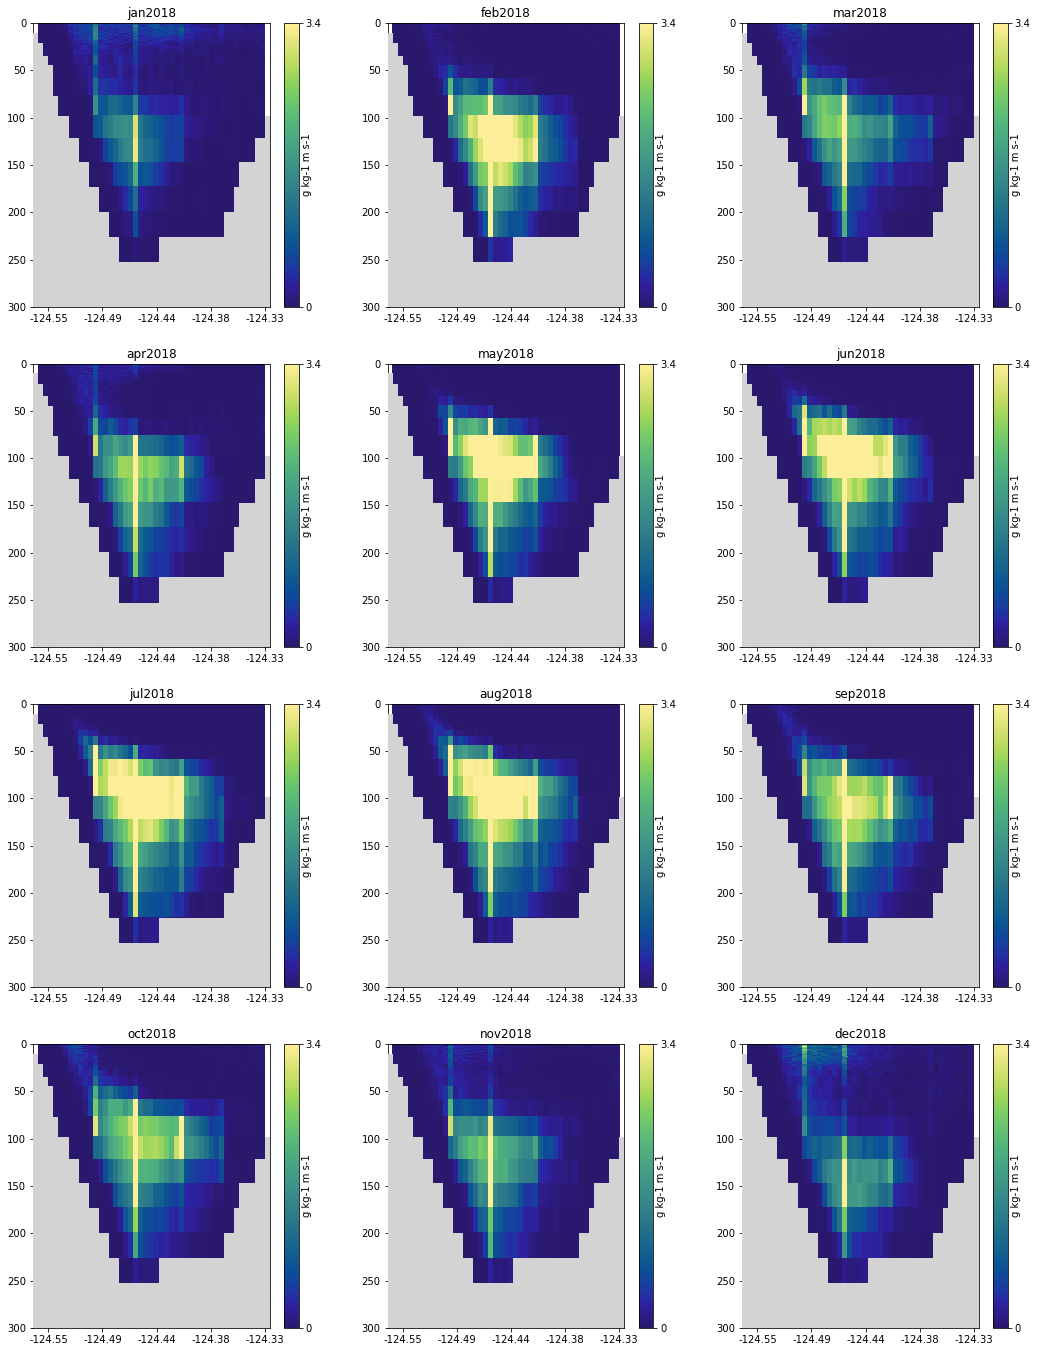

In [115]:
# for loop to get all 12 months at JR in 2018 - forward for now
str_mo = ['jan', 'feb', 'mar', 'apr','may', 'jun', 'jul', 'aug', 'sep','oct', 'nov', 'dec']
fig, ax = plt.subplots(4, 3, figsize = (18, 24))

k=0
for i in range(len(str_mo)):
    file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Car_Sal/forward_01'+str_mo[i]+'18/ariane_positions_quantitative.nc'
    mydata = xr.open_dataset(file)
    
    #in the format [tracer, jgridW, jgridE, figrid, maxdepth, ax, title]
    JRTracerFluxCS('salt', 18, 63, 377, 300, ax[i//3,k], str_mo[i]+"2018")
    
    if k == 2:
        k=0
    else:
        k +=1

## for 1 summer and 1 winter month plot JR CS flux seperately for each channel the water parcels end up in
i think January looks good as a winter "transient" flow and May looks good as an almost entirely "estuarine"

In [119]:
lonW, lonE, figrid, maxdepth = 18, 63, 377, 300
sections = [2,3,4,5,6] # admiralty, deception, rosario, san juan, haro
section_name = ['admiralty', 'deception', 'rosario', 'san juan', 'haro']

def JR_to_channels(tracername, section, ax, title):
    igrid = figrid-1
    fmask = mymesh.fmask[0, :, igrid]
    tmask = mymesh.tmask[0]
    nav_lon = mymesh.nav_lon[igrid]
    time = 720
    
    lons = mydata.init_lon[(mydata.final_section == section)]
    lats = mydata.init_lat[(mydata.final_section == section)]
    
    t_lons = mymesh.glamt[0, igrid]
    m2lon = ((t_lons[lonE]-t_lons[lonW])/(mymesh.e1t[0, igrid, lonW:lonE].sum()))
    t_dist = t_lons/m2lon
    t_depths = mymesh.gdept_1d[0,:]
    
    xs, ys = np.meshgrid(np.array(t_dist), np.array(t_depths))
    
    dist = lons/m2lon
    depths = depthf(mydata.init_z[(mydata.final_section == section)]-1.)[0]
    transports = mydata.init_transp[(mydata.final_section == section)]/time
    
    if tracername == 'salt' or tracername == 'silicon':
        tracer = mydata.init_salt[(mydata.final_section == section)]
        if tracername == 'salt':
            t_max = round(25 * 0.1,1)
            cmap = cm.haline
            units = 'g kg-1 m s-1'
        else:
            t_max = round(25 * 0.1,1)
            cmap = cm.matter
            units = 'mmol m-2 s-1'
    elif tracername == 'temp' or tracername == 'nitrate' or tracername == 'carbon':
        tracer = mydata.init_temp[(mydata.final_section == section)]
        if tracername == 'nitrate':
            t_max = round(15 * 0.1,1)
            cmap = cm.rain
            units = 'mmol m-2 s-1'
        else:
            t_max = round(1200 * 0.1,1)
            cmap = cm.turbid
            units = 'mmol m-2 s-1'
    else:
        print('incorrect tracer name, options are salt, temp, silicon, carbon, nitrate')

               
    H1, xedges1, yedges1 = np.histogram2d(dist, depths, bins=[np.array(t_dist[lonW-1:lonE]), t_depths],weights= transports, density= True)# vmax=vmax)

    H = binned_statistic_2d(dist, depths, tracer, statistic=np.mean, bins=[np.array(t_dist[lonW-1:lonE]), t_depths])
    _, xedges, yedges = np.histogram2d(dist, depths, bins = [np.array(t_dist[lonW-1:lonE]), t_depths])
       
    H_final = H1.T * H.statistic.T * float(sum(transports))
    np.nan_to_num(H_final, nan=0, copy=False)
    

    X, Y = np.meshgrid(xedges, yedges)
#     cmap.set_bad('grey', None)
    im = ax.pcolormesh(X, Y, H_final, vmax = t_max, vmin = 0, cmap=cmap)
    cb1 = fig.colorbar(im, ax=ax)
    cb1.set_ticks([0, t_max])
    cb1.set_ticklabels([0, t_max]) 
    cb1.set_label(units, labelpad=-20)
    
    pc = draw_patches(fmask, lonW-2, lonE, np.array(t_dist), np.array(t_depths))
    ax.add_collection(pc)

    ax.invert_yaxis()
    ax.set_xticks(np.linspace(t_dist[lonW+1], t_dist[lonE-1], 5))
    ax.set_xticklabels(np.round(np.linspace(t_lons[lonW+1], t_lons[lonE-1], 5),2))
    ax.set_xlim((t_dist[lonW-2], t_dist[lonE]))
    ax.set_ylim((maxdepth, 0))
    ax.set_title(str(title))
    mydata.close()

#### January

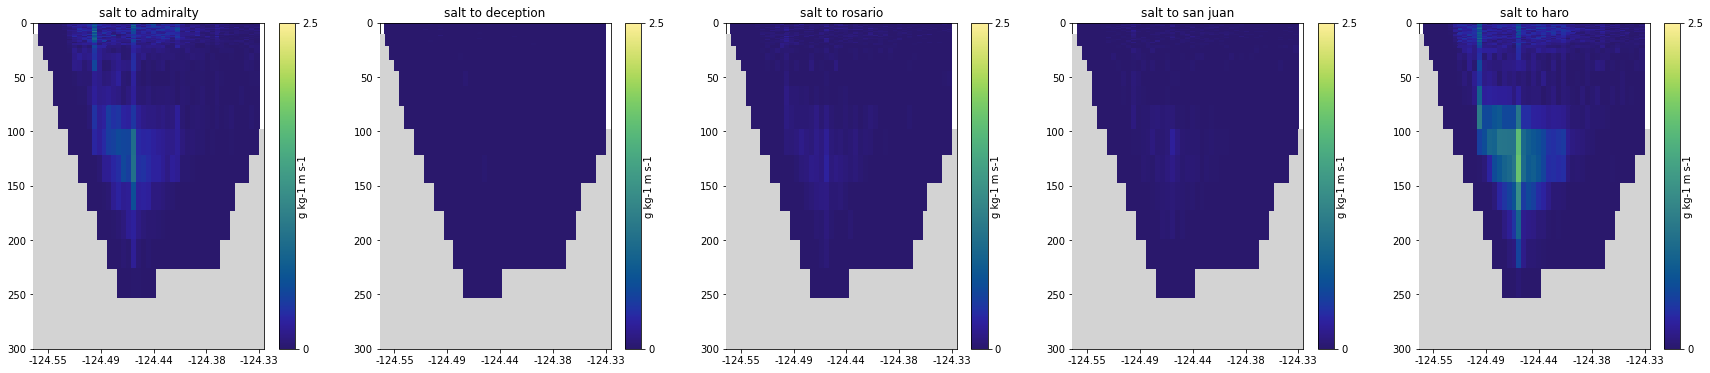

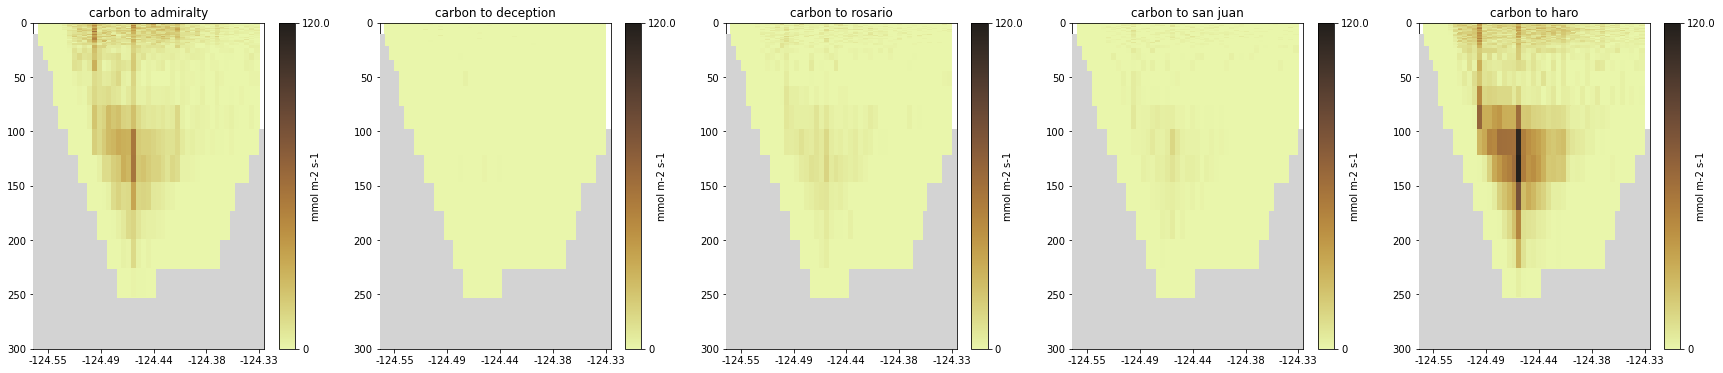

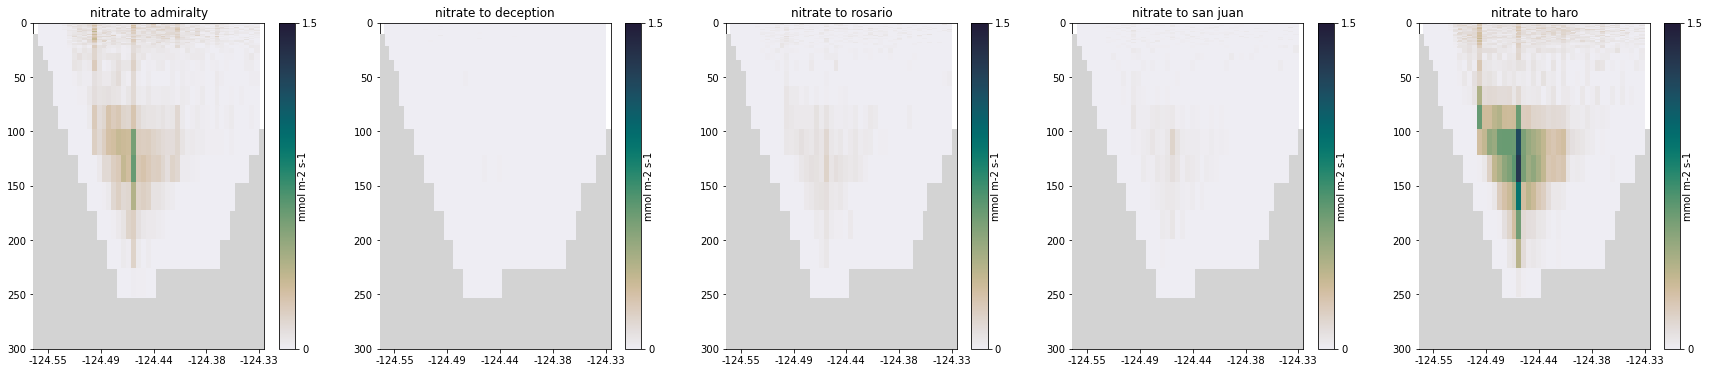

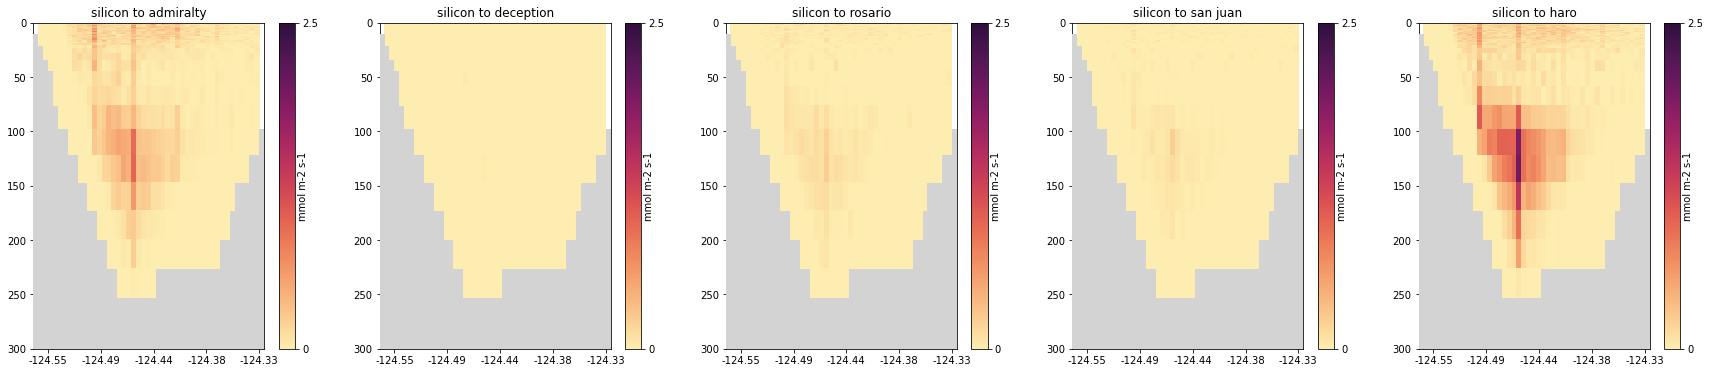

In [120]:
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Car_Sal/forward_01jan18/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)

fig, ax = plt.subplots(1, 5, figsize = (30, 6))
tracername = 'salt'
for i in range(len(sections)):
    JR_to_channels(tracername, sections[i], ax[i], tracername+" to "+section_name[i])
    
    
fig, ax = plt.subplots(1, 5, figsize = (30, 6))
tracername = 'carbon'
for i in range(len(sections)):
    JR_to_channels(tracername, sections[i], ax[i], tracername+" to "+section_name[i])
    
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Nit_Sil/forward_01jan18/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)

fig, ax = plt.subplots(1, 5, figsize = (30, 6))
tracername = 'nitrate'
for i in range(len(sections)):
    JR_to_channels(tracername, sections[i], ax[i], tracername+" to "+section_name[i])
    
fig, ax = plt.subplots(1, 5, figsize = (30, 6))
tracername = 'silicon'
for i in range(len(sections)):
    JR_to_channels(tracername, sections[i], ax[i], tracername+" to "+section_name[i])

### May

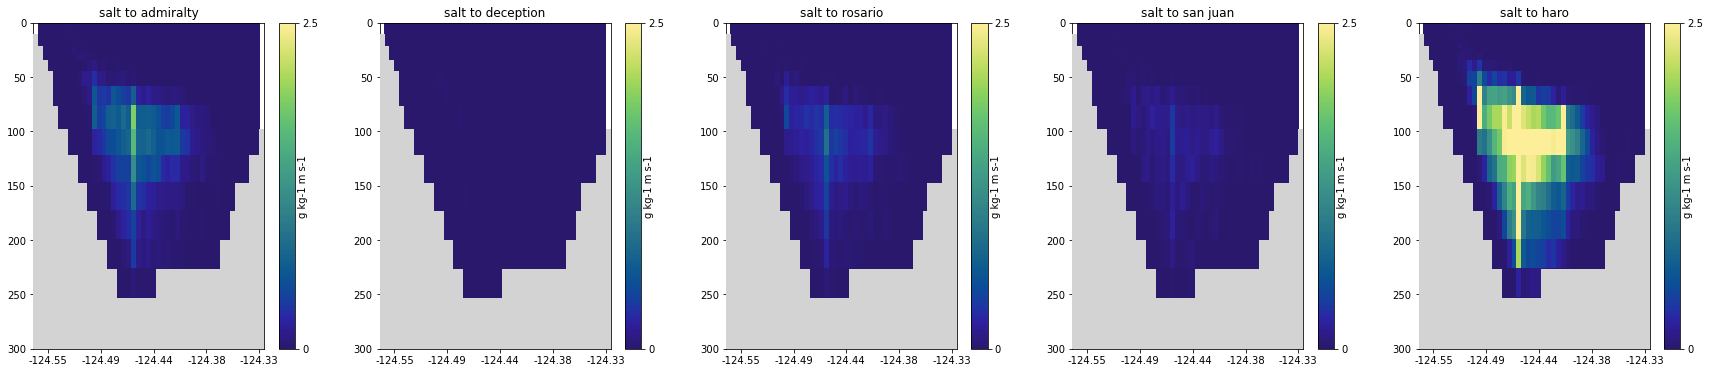

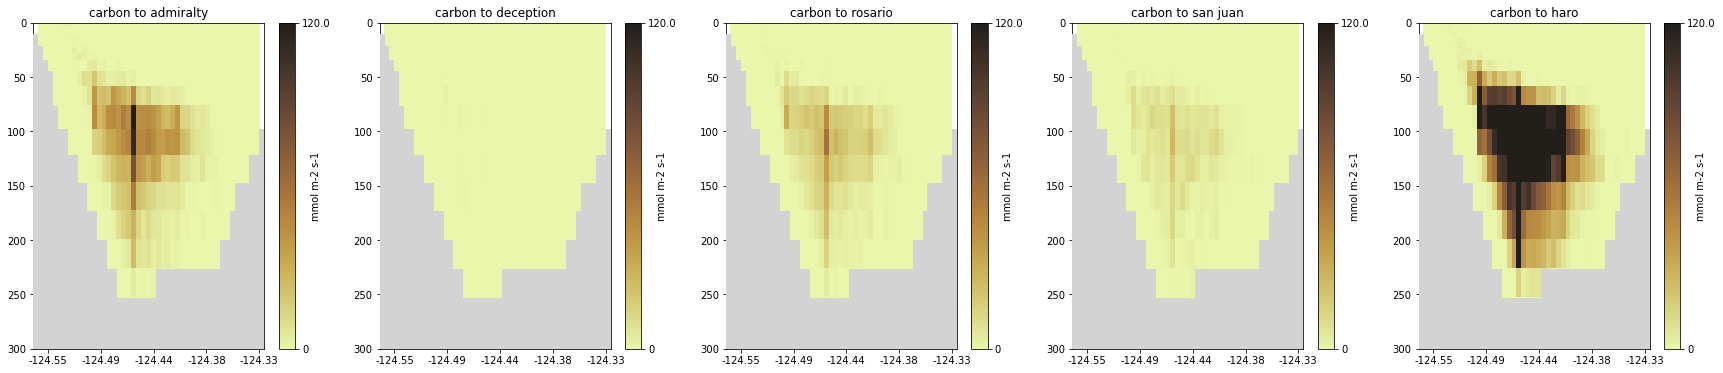

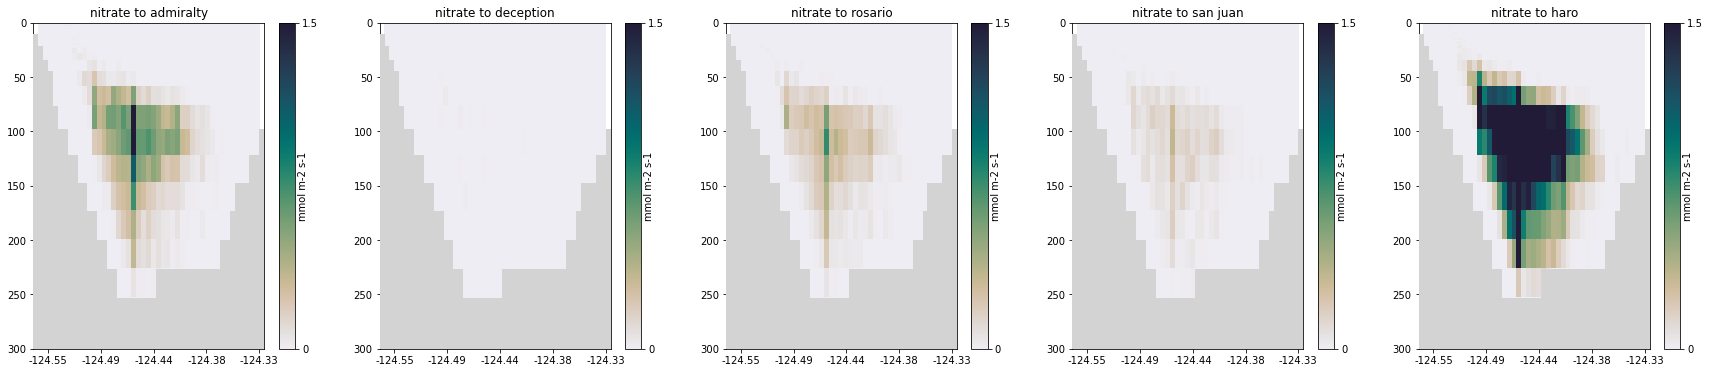

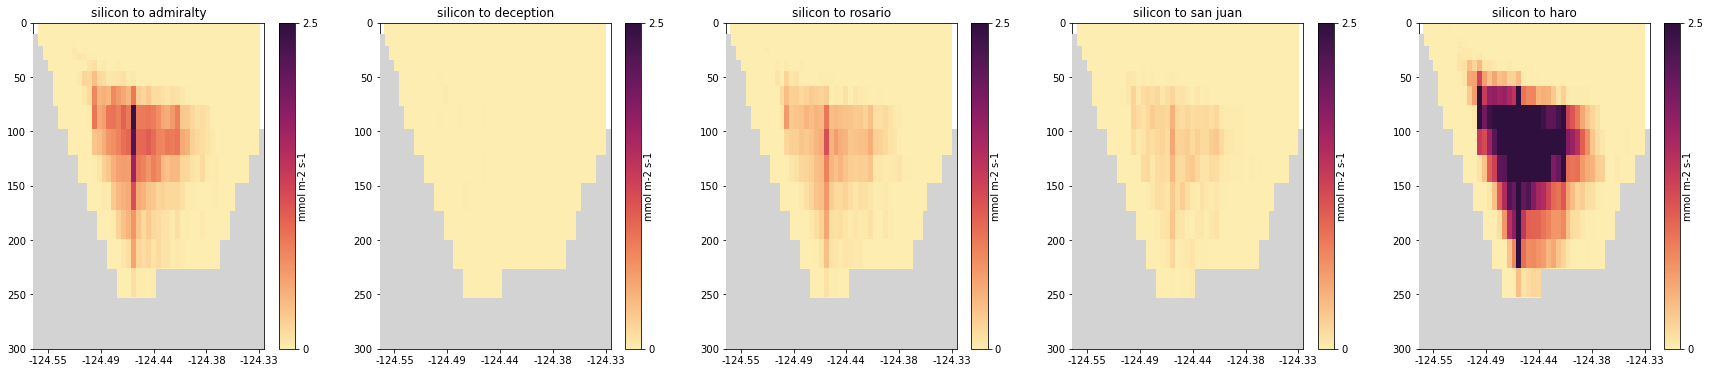

In [121]:
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Car_Sal/forward_01may18/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)

fig, ax = plt.subplots(1, 5, figsize = (30, 6))
tracername = 'salt'
for i in range(len(sections)):
    JR_to_channels(tracername, sections[i], ax[i], tracername+" to "+section_name[i])
    
    
fig, ax = plt.subplots(1, 5, figsize = (30, 6))
tracername = 'carbon'
for i in range(len(sections)):
    JR_to_channels(tracername, sections[i], ax[i], tracername+" to "+section_name[i])
    
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Nit_Sil/forward_01may18/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)

fig, ax = plt.subplots(1, 5, figsize = (30, 6))
tracername = 'nitrate'
for i in range(len(sections)):
    JR_to_channels(tracername, sections[i], ax[i], tracername+" to "+section_name[i])
    
fig, ax = plt.subplots(1, 5, figsize = (30, 6))
tracername = 'silicon'
for i in range(len(sections)):
    JR_to_channels(tracername, sections[i], ax[i], tracername+" to "+section_name[i])

### Now lets make a nice lil histogram to look at the composition of the water and how it changes

##### we want to do this for allllll the years though

In [8]:
yearjumps = [0,1,-2,1,0,1,0,1,1,0,1,0]

In [9]:
c = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
labels = ['2016','2017','2018','2019','2020']

In [10]:
def winter_months(variable, fall, spring):
    jan_start = 1
    dec_end = 720+(11*720+(sum(yearjumps[:12]*24)))
    
    mar_end = 720+(spring*720+(sum(yearjumps[:3]*24)))
    oct_start = 1+(fall*720+(sum(yearjumps[:10]*24)))
    
    
#     time = 720
    time1 = mar_end - jan_start +1
    time2 = dec_end - oct_start +1
    time = time1+ time2
    
    tracer = np.append(mydata[variable][(mydata.final_section != 0) & (mydata.init_t >= jan_start) & (mydata.init_t <= mar_end)],mydata[variable][(mydata.final_section != 0) & (mydata.init_t >= oct_start) & (mydata.init_t <= dec_end)])
    transport = np.append(mydata.init_transp[(mydata.final_section != 0) & (mydata.init_t >= jan_start) & (mydata.init_t <= mar_end)]/time,mydata.init_transp[(mydata.final_section != 0) & (mydata.init_t >= oct_start) & (mydata.init_t <= dec_end)]/time)
    depths = np.append(depthf(mydata.init_z[(mydata.final_section != 0) & (mydata.init_t >= jan_start) & (mydata.init_t <= mar_end)]-1.)[0],depthf(mydata.init_z[(mydata.final_section != 0) & (mydata.init_t >= oct_start) & (mydata.init_t <= dec_end)]-1.)[0])
    lons = np.append(mydata.init_lon[(mydata.final_section != 0) & (mydata.init_t >= jan_start) & (mydata.init_t <= mar_end)],mydata.init_lon[(mydata.final_section != 0) & (mydata.init_t >= oct_start) & (mydata.init_t <= dec_end)])
        
    return tracer, transport,lons, depths

In [11]:
def summer_months(variable, start, end):
    apr_start = 1+(start*720+(sum(yearjumps[:4]*24)))
    sep_end = 720+(end*720+(sum(yearjumps[:9]*24)))
    time = sep_end - apr_start +1
    
    tracer = mydata[variable][(mydata.final_section != 0) & (mydata.init_t >= apr_start) & (mydata.init_t <= sep_end)]
    transport = mydata.init_transp[(mydata.final_section != 0) & (mydata.init_t >= apr_start) & (mydata.init_t <= sep_end)]/time
    depths = depthf(mydata.init_z[(mydata.final_section != 0) & (mydata.init_t >= apr_start) & (mydata.init_t <= sep_end)]-1.)[0]
    lons = mydata.init_lon[(mydata.final_section != 0) & (mydata.init_t >= apr_start) & (mydata.init_t <= sep_end)]
        
    return tracer, transport,lons, depths

In [12]:
def winter_monthlies(variable, folder, yy, fall, spring): #not to be confused with winter_months - this is to do the same thimg but for runs done month by month
    time = 720
    month_max = ['jan', 'feb', 'mar', 'apr', 'sep', 'oct','nov', 'dec']
    months = month_max[:spring] + month_max[fall-4:]
    files = ['/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_'+folder+'/forward_01'+month+str(yy)+'/ariane_positions_quantitative.nc' for month in months]
    tracer = []
    transport = []
    depths = []
    lons = []
    
    jan_start = 1
    mar_end = 720+(2*720+(sum(yearjumps[:3]*24)))
    oct_start = 1+(9*720+(sum(yearjumps[:10]*24)))
    dec_end = 720+(11*720+(sum(yearjumps[:12]*24)))
    time1 = mar_end - jan_start +1
    time2 = dec_end - oct_start +1
    time = time1+ time2

    for file in files:
        mydata = xr.open_dataset(file)
        tracer = np.append(tracer, mydata[variable][(mydata.final_section != 0)])
        transport = np.append(transport, mydata.init_transp[(mydata.final_section != 0)])
        depths = np.append(depths, depthf(mydata.init_z[(mydata.final_section != 0)]-1.)[0])
        lons = np.append(lons, mydata.init_lon[(mydata.final_section != 0)])
        
    return tracer, transport/time,lons, depths

In [13]:
def summer_monthlies(variable, folder, yy, start, end): #not to be confused with summer_months - this is to do the same thimg but for runs done month by month
    time = 720
    month_max = ['apr', 'may', 'jun', 'jul', 'aug', 'sep']
    months = month_max[start-2:end-2]
    files = ['/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_'+folder+'/forward_01'+month+str(yy)+'/ariane_positions_quantitative.nc' for month in months]
    tracer = []
    transport = []
    depths = []
    lons = []
    
    apr_start = 1+(3*720+(sum(yearjumps[:4]*24)))
    sep_end = 720+(8*720+(sum(yearjumps[:9]*24)))
    time = sep_end - apr_start +1

    for file in files:
        mydata = xr.open_dataset(file)
        tracer = np.append(tracer, mydata[variable][(mydata.final_section != 0)])
        transport = np.append(transport, mydata.init_transp[(mydata.final_section != 0)])
        depths = np.append(depths, depthf(mydata.init_z[(mydata.final_section != 0)]-1.)[0])
        lons = np.append(lons, mydata.init_lon[(mydata.final_section != 0)])
        
    return tracer, transport/time,lons, depths

In [14]:
up_end = [8, 9, 8, 10, 9] #2016 = sep, 2017 = oct, 2018 = sep, 2019 = nov, 2020 = oct
up_start = [3, 4, 2, 3, 2] #2016 = apr, 2017 = may, 2018 = mar, 2019 = apr, 2020 = mar

fall_start = [8,9,8,10,9]
spr_end = [3,4,2,3,2]

In [15]:
#get all the data
#2016
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan16/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
tracerW16, transportW16, lonsW16, depthW16 = winter_months('init_temp', fall_start[0], spr_end[0])
tracerS16, transportS16, lonsS16, depthS16 = summer_months('init_temp', up_start[0], up_end[0])

#2017
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan17/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
tracerW17, transportW17, lonsW17, depthW17 = winter_months('init_temp', fall_start[1], spr_end[1])
tracerS17, transportS17, lonsS17, depthS17 = summer_months('init_temp', up_start[1], up_end[1])

#2018
tracerW18, transportW18, lonsW18, depthW18 = winter_monthlies('init_temp', '1hr', 18, fall_start[2], spr_end[2])
tracerS18, transportS18, lonsS18, depthS18 = summer_monthlies('init_temp', '1hr', 18, up_start[2], up_end[2])

#2019
tracerW19, transportW19, lonsW19, depthW19 = winter_monthlies('init_temp', '1hr', 19, fall_start[3], spr_end[3])
tracerS19, transportS19, lonsS19, depthS19 = summer_monthlies('init_temp', '1hr', 19, up_start[3], up_end[3])

#2020
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan20/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
tracerW20, transportW20, lonsW20, depthW20 = winter_months('init_temp', fall_start[4], spr_end[4])
tracerS20, transportS20, lonsS20, depthS20 = summer_months('init_temp', up_start[4], up_end[4])

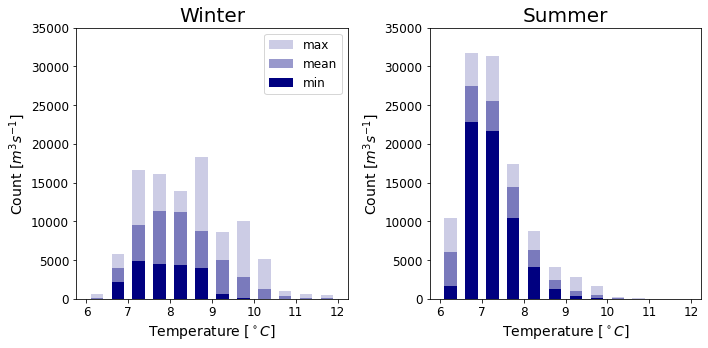

In [16]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
plt.rcParams['font.size'] = 12
bins = np.arange(6,12.5,0.5)

#plt winter
jan_temp,x,_ = ax[0].hist([tracerW16,tracerW17,tracerW18,tracerW19,tracerW20], bins=bins, weights= [transportW16,transportW17,transportW18,transportW19,transportW20], color=c, alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(jan_temp,axis=0)
mini = np.min(jan_temp,axis=0)
maxi = np.max(jan_temp,axis=0)

ax[0].bar(bin_centers,maxi,width = 0.3,color='navy',alpha=0.2,label='max')
ax[0].bar(bin_centers,mean,width = 0.3, color='navy',alpha=0.4,label='mean')
ax[0].bar(bin_centers, mini,width = 0.3, color='navy',label='min')

ax[0].set_title('Winter', fontsize = 20)
ax[0].set_ylabel('Count [$m^{3}s^{-1}$]', fontsize = 14)
ax[0].set_xlabel('Temperature [$^\circ C$]', fontsize = 14)
ax[0].set_ylim([0,35000])
ax[0].legend(fontsize = 12)

#plt may
may_temp,x,_ = ax[1].hist([tracerS16,tracerS17,tracerS18,tracerS19,tracerS20], bins=bins, weights= [transportS16,transportS17,transportS18,transportS19,transportS20],  color=c, alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(may_temp,axis=0)
mini = np.min(may_temp,axis=0)
maxi = np.max(may_temp,axis=0)

ax[1].bar(bin_centers,maxi,width = 0.3,color='navy',alpha=0.2,label='max')
ax[1].bar(bin_centers,mean,width = 0.3, color='navy',alpha=0.4,label='mean')
ax[1].bar(bin_centers, mini,width = 0.3, color='navy',label='min')

ax[1].set_title('Summer', fontsize = 20)
ax[1].set_ylabel('Count [$m^{3}s^{-1}$]', fontsize = 14)
ax[1].set_xlabel('Temperature [$^\circ C$]', fontsize = 14)
ax[1].set_ylim([0,35000])
# ax[1].legend(fontsize = 12)

plt.tight_layout()
plt.savefig("./figures/temperature_hystogram.pdf")

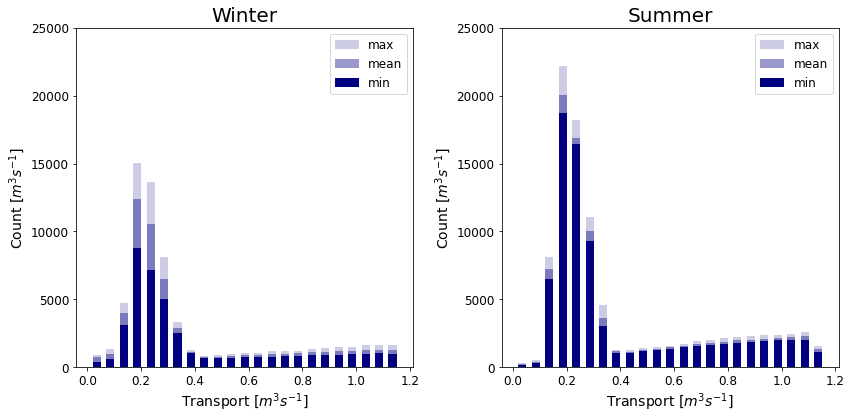

In [22]:
fig, ax = plt.subplots(1, 2, figsize = (12, 6))
plt.rcParams['font.size'] = 12
bins=np.arange(0.01,1.2,0.05)

#plt winter
jan_flux,x,_ = ax[0].hist([transportW16,transportW17,transportW18,transportW19,transportW20], bins=bins, weights= [transportW16,transportW17,transportW18,transportW19,transportW20], color=c, alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(jan_flux,axis=0)
mini = np.min(jan_flux,axis=0)
maxi = np.max(jan_flux,axis=0)

ax[0].bar(bin_centers,maxi,width = 0.03,color='navy',alpha=0.2,label='max')
ax[0].bar(bin_centers,mean,width = 0.03, color='navy',alpha=0.4,label='mean')
ax[0].bar(bin_centers, mini,width = 0.03, color='navy',label='min')

ax[0].set_title('Winter', fontsize = 20)
ax[0].set_ylabel('Count [$m^{3}s^{-1}$]', fontsize = 14)
ax[0].set_xlabel('Transport [$m^{3}s^{-1}$]', fontsize = 14)
ax[0].set_ylim([0,25000])
ax[0].legend(fontsize = 12)

#plt may
may_flux,x,_ = ax[1].hist([transportS16,transportS17,transportS18,transportS19,transportS20], bins=bins, weights= [transportS16,transportS17,transportS18,transportS19,transportS20],  color=c, alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(may_flux,axis=0)
mini = np.min(may_flux,axis=0)
maxi = np.max(may_flux,axis=0)

ax[1].bar(bin_centers,maxi,width = 0.03,color='navy',alpha=0.2,label='max')
ax[1].bar(bin_centers,mean,width = 0.03, color='navy',alpha=0.4,label='mean')
ax[1].bar(bin_centers, mini,width = 0.03, color='navy',label='min')

ax[1].set_title('Summer', fontsize = 20)
ax[1].set_ylabel('Count [$m^{3}s^{-1}$]', fontsize = 14)
ax[1].set_xlabel('Transport [$m^{3}s^{-1}$]', fontsize = 14)
ax[1].set_ylim([0,25000])
ax[1].legend(fontsize = 12)

plt.tight_layout()

In [17]:
#get all the data
#2016
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_Car_Sal/forward_01jan16/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
tracerW16, transportW16, lonsW16, depthW16 = winter_months('init_salt', fall_start[0], spr_end[0])
tracerS16, transportS16, lonsS16, depthS16 = summer_months('init_salt', up_start[0], up_end[0])

#2017
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_Car_Sal/forward_01jan17/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
tracerW17, transportW17, lonsW17, depthW17 = winter_months('init_salt', fall_start[1], spr_end[1])
tracerS17, transportS17, lonsS17, depthS17 = summer_months('init_salt', up_start[1], up_end[1])

#2018
tracerW18, transportW18, lonsW18, depthW18 = winter_monthlies('init_salt', 'Car_Sal', 18, fall_start[2], spr_end[2])
tracerS18, transportS18, lonsS18, depthS18 = summer_monthlies('init_salt', 'Car_Sal', 18, up_start[2], up_end[2])

#2019
tracerW19, transportW19, lonsW19, depthW19 = winter_monthlies('init_salt', 'Car_Sal', 19, fall_start[3], spr_end[3])
tracerS19, transportS19, lonsS19, depthS19 = summer_monthlies('init_salt', 'Car_Sal', 19, up_start[3], up_end[3])

#2020
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_Car_Sal/forward_01jan20/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
tracerW20, transportW20, lonsW20, depthW20 = winter_months('init_salt', fall_start[4], spr_end[4])
tracerS20, transportS20, lonsS20, depthS20 = summer_months('init_salt', up_start[4], up_end[4])

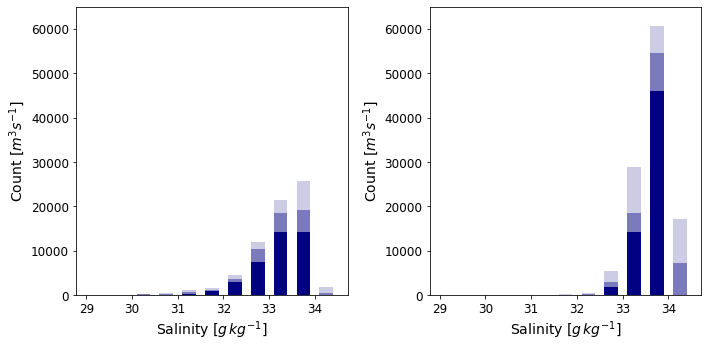

In [18]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
plt.rcParams['font.size'] = 12

#plt winter
jan_sal,x,_ = ax[0].hist([tracerW16,tracerW17,tracerW18,tracerW19,tracerW20], bins=np.arange(29,35,0.5), weights= [transportW16,transportW17,transportW18,transportW19,transportW20], color=c, alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(jan_sal,axis=0)
mini = np.min(jan_sal,axis=0)
maxi = np.max(jan_sal,axis=0)

ax[0].bar(bin_centers,maxi,width = 0.3,color='navy',alpha=0.2,label='max')
ax[0].bar(bin_centers,mean,width = 0.3, color='navy',alpha=0.4,label='mean')
ax[0].bar(bin_centers, mini,width = 0.3, color='navy',label='min')

# ax[0].set_title('Winter')
ax[0].set_ylabel('Count [$m^{3}s^{-1}$]', fontsize=14)
ax[0].set_xlabel('Salinity [$g \, kg^{-1}$]', fontsize=14)
ax[0].set_ylim([0,65000])
# ax[0].legend()

#plt may
may_sal,x,_ = ax[1].hist([tracerS16,tracerS17,tracerS18,tracerS19,tracerS20], bins=np.arange(29,35,0.5), weights= [transportS16,transportS17,transportS18,transportS19,transportS20],  color=c, alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(may_sal,axis=0)
mini = np.min(may_sal,axis=0)
maxi = np.max(may_sal,axis=0)

ax[1].bar(bin_centers,maxi,width = 0.3,color='navy',alpha=0.2,label='max')
ax[1].bar(bin_centers,mean,width = 0.3, color='navy',alpha=0.4,label='mean')
ax[1].bar(bin_centers, mini,width = 0.3, color='navy',label='min')

# ax[1].set_title('Summer')
ax[1].set_ylabel('Count [$m^{3}s^{-1}$]', fontsize=14)
ax[1].set_xlabel('Salinity [$g \, kg^{-1}$]', fontsize=14)
ax[1].set_ylim([0,65000])
# ax[1].legend()

plt.tight_layout()
plt.savefig("./figures/salt_histogram.pdf")

In [19]:
#CARBON
bins = np.arange(2000,2350,25)
time=720

#get all the data
#2016
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_Car_Sal/forward_01jan16/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
tracerW16, transportW16, lonsW16, depthW16 = winter_months('init_temp', fall_start[0], spr_end[0])
tracerS16, transportS16, lonsS16, depthS16 = summer_months('init_temp', up_start[0], up_end[0])

#2017
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_Car_Sal/forward_01jan17/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
tracerW17, transportW17, lonsW17, depthW17 = winter_months('init_temp', fall_start[1], spr_end[1])
tracerS17, transportS17, lonsS17, depthS17 = summer_months('init_temp', up_start[1], up_end[1])

#2018
tracerW18, transportW18, lonsW18, depthW18 = winter_monthlies('init_temp', 'Car_Sal', 18, fall_start[2], spr_end[2])
tracerS18, transportS18, lonsS18, depthS18 = summer_monthlies('init_temp', 'Car_Sal', 18, up_start[2], up_end[2])

#2019
tracerW19, transportW19, lonsW19, depthW19 = winter_monthlies('init_temp', 'Car_Sal', 19, fall_start[3], spr_end[3])
tracerS19, transportS19, lonsS19, depthS19 = summer_monthlies('init_temp', 'Car_Sal', 19, up_start[3], up_end[3])

#2020
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_Car_Sal/forward_01jan20/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
tracerW20, transportW20, lonsW20, depthW20 = winter_months('init_temp', fall_start[4], spr_end[4])
tracerS20, transportS20, lonsS20, depthS20 = summer_months('init_temp', up_start[4], up_end[4])

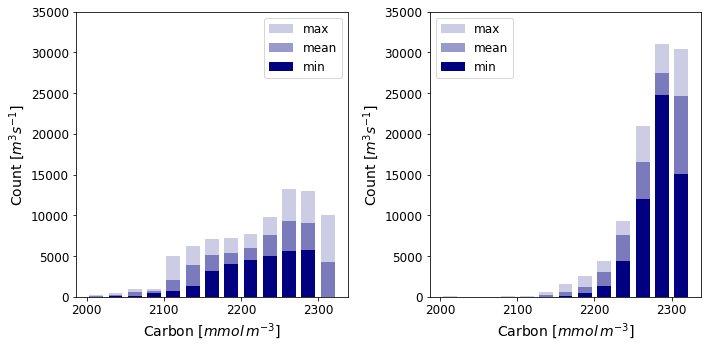

In [20]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))

#plt winter
jan_car,x,_ = ax[0].hist([tracerW16,tracerW17,tracerW18,tracerW19,tracerW20], bins=bins, weights= [transportW16,transportW17,transportW18,transportW19,transportW20], color=c, alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(jan_car,axis=0)
mini = np.min(jan_car,axis=0)
maxi = np.max(jan_car,axis=0)

ax[0].bar(bin_centers,maxi,width=18, color='navy',alpha=0.2,label='max')
ax[0].bar(bin_centers,mean,width=18, color='navy',alpha=0.4,label='mean')
ax[0].bar(bin_centers, mini,width=18, color='navy',label='min')

# ax[0].set_title('Winter')
ax[0].set_xlabel('Carbon [$mmol \, m^{-3}$]', fontsize = 14)
ax[0].set_ylabel('Count [$m^{3}s^{-1}$]', fontsize = 14)
ax[0].set_ylim([0,35000])
ax[0].legend(fontsize = 12)

#plt may
may_car,x,_ = ax[1].hist([tracerS16,tracerS17,tracerS18,tracerS19,tracerS20], bins=bins, weights= [transportS16,transportS17,transportS18,transportS19,transportS20],  color=c, alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(may_car,axis=0)
mini = np.min(may_car,axis=0)
maxi = np.max(may_car,axis=0)

ax[1].bar(bin_centers,maxi,width=18, color='navy',alpha=0.2,label='max')
ax[1].bar(bin_centers,mean,width=18, color='navy',alpha=0.4,label='mean')
ax[1].bar(bin_centers, mini,width=18, color='navy',label='min')

# ax[1].set_title('Summer')
ax[1].set_xlabel('Carbon [$mmol \, m^{-3}$]', fontsize = 14)
ax[1].set_ylabel('Count [$m^{3}s^{-1}$]', fontsize = 14)
ax[1].set_ylim([0,35000])
ax[1].legend(fontsize = 12)

plt.tight_layout()
plt.savefig("./figures/carbon_hystogram.pdf")

In [21]:
#NITRATE
bins = np.arange(5,35,2.5)
time=720

#get all the data
#2016
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_Nit_Sil/forward_01jan16/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
tracerW16, transportW16, _, _ = winter_months('init_temp', fall_start[0], spr_end[0])
tracerS16, transportS16, _, _ = summer_months('init_temp', up_start[0], up_end[0])

#2017
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_Nit_Sil/forward_01jan17/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
tracerW17, transportW17, _, _ = winter_months('init_temp', fall_start[1], spr_end[1])
tracerS17, transportS17, _, _ = summer_months('init_temp', up_start[1], up_end[1])

#2018
tracerW18, transportW18, _, _ = winter_monthlies('init_temp', 'Nit_Sil', 18, fall_start[2], spr_end[2])
tracerS18, transportS18, _, _ = summer_monthlies('init_temp', 'Nit_Sil', 18, up_start[2], up_end[2])

#2019
tracerW19, transportW19, _, _ = winter_monthlies('init_temp', 'Nit_Sil', 19, fall_start[3], spr_end[3])
tracerS19, transportS19, _, _ = summer_monthlies('init_temp', 'Nit_Sil', 19, up_start[3], up_end[3])

#2020
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_Nit_Sil/forward_01jan20/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
tracerW20, transportW20, _, _ = winter_months('init_temp', fall_start[4], spr_end[4])
tracerS20, transportS20, _, _ = summer_months('init_temp', up_start[4], up_end[4])

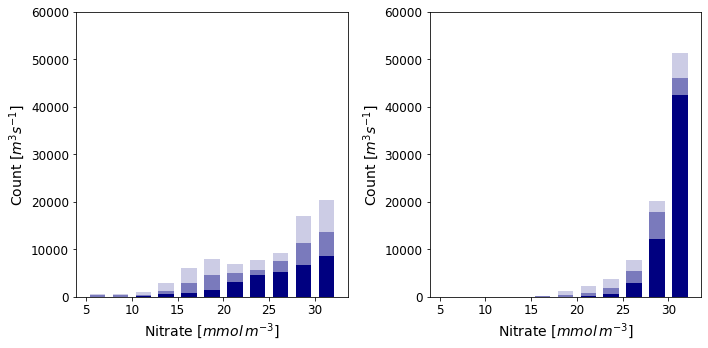

In [22]:

fig, ax = plt.subplots(1, 2, figsize = (10, 5))

#plt winter
jan_nit,x,_ = ax[0].hist([tracerW16,tracerW17,tracerW18,tracerW19,tracerW20], bins=bins, weights= [transportW16,transportW17,transportW18,transportW19,transportW20], color=c, alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(jan_nit,axis=0)
mini = np.min(jan_nit,axis=0)
maxi = np.max(jan_nit,axis=0)

ax[0].bar(bin_centers,maxi,width=1.7, color='navy',alpha=0.2,label='max')
ax[0].bar(bin_centers,mean,width=1.7, color='navy',alpha=0.4,label='mean')
ax[0].bar(bin_centers, mini,width=1.7, color='navy',label='min')

# ax[0].set_title('Winter')
ax[0].set_xlabel('Nitrate [$mmol \, m^{-3}$]', fontsize = 14)
ax[0].set_ylabel('Count [$m^{3}s^{-1}$]', fontsize = 14)
ax[0].set_ylim([0,60000])
# ax[0].legend(fontsize = 12)

#plt may
may_nit,x,_ = ax[1].hist([tracerS16,tracerS17,tracerS18,tracerS19,tracerS20], bins=bins, weights= [transportS16,transportS17,transportS18,transportS19,transportS20],  color=c, alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(may_nit,axis=0)
mini = np.min(may_nit,axis=0)
maxi = np.max(may_nit,axis=0)

ax[1].bar(bin_centers,maxi,width=1.7, color='navy',alpha=0.2,label='max')
ax[1].bar(bin_centers,mean,width=1.7, color='navy',alpha=0.4,label='mean')
ax[1].bar(bin_centers, mini,width=1.7, color='navy',label='min')

# ax[1].set_title('Summer')
ax[1].set_xlabel('Nitrate [$mmol \, m^{-3}$]', fontsize = 14)
ax[1].set_ylabel('Count [$m^{3}s^{-1}$]', fontsize = 14)
ax[1].set_ylim([0,60000])
# ax[1].legend(fontsize = 12)

plt.tight_layout()
plt.savefig("./figures/nitrate_hystogram.pdf")

In [ ]:
#SILICON
bins = np.arange(20,50,2.5)
time=720

#get all the data
#2016
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_Nit_Sil/forward_01jan16/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
tracerW16, transportW16, _, _ = winter_months('init_salt', fall_start[0], spr_end[0])
tracerS16, transportS16, _, _ = summer_months('init_salt', up_start[0], up_end[0])

#2017
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_Nit_Sil/forward_01jan17/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
tracerW17, transportW17, _, _ = winter_months('init_salt', fall_start[1], spr_end[1])
tracerS17, transportS17, _, _ = summer_months('init_salt', up_start[1], up_end[1])

#2018
tracerW18, transportW18, _, _ = winter_monthlies('init_salt', 'Nit_Sil', 18, fall_start[2], spr_end[2])
tracerS18, transportS18, _, _ = summer_monthlies('init_salt', 'Nit_Sil', 18, up_start[2], up_end[2])

#2019
tracerW19, transportW19, _, _ = winter_monthlies('init_salt', 'Nit_Sil', 19, fall_start[3], spr_end[3])
tracerS19, transportS19, _, _ = summer_monthlies('init_salt', 'Nit_Sil', 19, up_start[3], up_end[3])

#2020
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_Nit_Sil/forward_01jan20/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
tracerW20, transportW20, _, _ = winter_months('init_salt', fall_start[4], spr_end[4])
tracerS20, transportS20, _, _ = summer_months('init_salt', up_start[4], up_end[4])

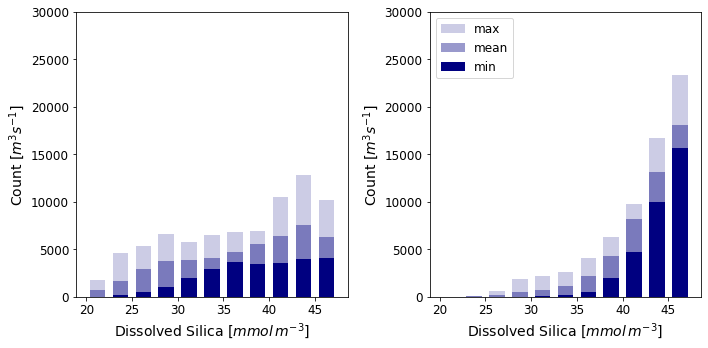

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))

#plt winter
jan_sil,x,_ = ax[0].hist([tracerW16,tracerW17,tracerW18,tracerW19,tracerW20], bins=bins, weights= [transportW16,transportW17,transportW18,transportW19,transportW20], color=c, alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(jan_sil,axis=0)
mini = np.min(jan_sil,axis=0)
maxi = np.max(jan_sil,axis=0)

ax[0].bar(bin_centers,maxi,width=1.7, color='navy',alpha=0.2,label='max')
ax[0].bar(bin_centers,mean,width=1.7, color='navy',alpha=0.4,label='mean')
ax[0].bar(bin_centers, mini,width=1.7, color='navy',label='min')

# ax[0].set_title('Winter')
ax[0].set_xlabel('Dissolved Silica [$mmol \, m^{-3}$]', fontsize = 14)
ax[0].set_ylabel('Count [$m^{3}s^{-1}$]', fontsize = 14)
ax[0].set_ylim([0,30000])
# ax[0].legend(fontsize = 12)

#plt may
may_sil,x,_ = ax[1].hist([tracerS16,tracerS17,tracerS18,tracerS19,tracerS20], bins=bins, weights= [transportS16,transportS17,transportS18,transportS19,transportS20],  color=c, alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(may_sil,axis=0)
mini = np.min(may_sil,axis=0)
maxi = np.max(may_sil,axis=0)

ax[1].bar(bin_centers,maxi,width=1.7, color='navy',alpha=0.2,label='max')
ax[1].bar(bin_centers,mean,width=1.7, color='navy',alpha=0.4,label='mean')
ax[1].bar(bin_centers, mini,width=1.7, color='navy',label='min')

# ax[1].set_title('Summer')
ax[1].set_xlabel('Dissolved Silica [$mmol \, m^{-3}$]', fontsize = 14)
ax[1].set_ylabel('Count [$m^{3}s^{-1}$]', fontsize = 14)
ax[1].set_ylim([0,30000])
ax[1].legend(fontsize = 12)

plt.tight_layout()
plt.savefig("./figures/silica_hystogram.pdf")

### curious about what delta CS plots would look like

In [12]:
def JRTracerFluxCS_delta(tracername, lonW, lonE, figrid, maxdepth, ax, title):
    igrid = figrid-1
    fmask = mymesh.fmask[0, :, igrid]
    tmask = mymesh.tmask[0]
    nav_lon = mymesh.nav_lon[igrid]
    time = 720
    
    lons = mydata.init_lon[(mydata.final_section != 0)]
    lats = mydata.init_lat[(mydata.final_section != 0)]
    
    t_lons = mymesh.glamt[0, igrid]
    m2lon = ((t_lons[lonE]-t_lons[lonW])/(mymesh.e1t[0, igrid, lonW:lonE].sum()))
    t_dist = t_lons/m2lon
    t_depths = mymesh.gdept_1d[0,:]
    
    xs, ys = np.meshgrid(np.array(t_dist), np.array(t_depths))
    
    dist = lons/m2lon
    depths = depthf(mydata.init_z[(mydata.final_section != 0)]-1.)[0]
    transports = mydata.init_transp[(mydata.final_section != 0)]/time
    
    #ambient concentrations from "AmbientTracerConc.ipynb"
    amC = 2104.4632427854353 #mmol/m3
    amSi = 37.46235074714988 #mmol/m3
    amSa = 31.417757428541577 #g/kg
    amN = 23.037677314276408 #mmol/m3
    amT = 9.005697383879731 #deg C
    
    if tracername == 'salt' or tracername == 'silicon':
        tracer = mydata.init_salt[(mydata.final_section != 0)]
        if tracername == 'salt':
            t_max = 0.12
            units = 'g kg-1 m s-1'
            tracer -= amSa
        else:
            t_max = 0.15
            units = 'mmol m-2 s-1'
            tracer -= amSi
    elif tracername == 'temp' or tracername == 'nitrate' or tracername == 'carbon':
        tracer = mydata.init_temp[(mydata.final_section != 0)]
        if tracername == 'nitrate':
            t_max = 0.15
            units = 'mmol m-2 s-1'
            tracer -= amN
        elif tracername == 'temp':
            t_max = 0.12
            units = '$^\circ C$'
            tracer -= amT
        else:
            t_max = 0.12         
            units = 'mmol m-2 s-1'
            tracer -= amC
    else:
        print('incorrect tracer name, options are salt, temp, silicon, carbon, nitrate')

    weight = tracer*transports           
    H1, xedges1, yedges1 = np.histogram2d(dist, depths, bins=[np.array(t_dist[lonW-1:lonE]), t_depths],weights=weight, density= True)
       
    H_final = H1.T * float(sum(transports))
    np.nan_to_num(H_final, nan=0, copy=False)
    
    h= H_final
    h[:,11] = H_final[:,11]/2.6
    h[:,19] = H_final[:,19]/2.5
    h[:,28] = H_final[:,28]/2
    h[:,36] = H_final[:,36]/2

    X, Y = np.meshgrid(xedges1, yedges1)
    cmap = cm.balance
    im = ax.pcolormesh(X, Y, h, vmax = t_max, vmin = -t_max, cmap=cmap)
    cb1 = fig.colorbar(im, ax=ax)
    cb1.set_ticks([-t_max, t_max])
    cb1.set_ticklabels([-t_max, t_max]) 
    cb1.set_label(units, labelpad=-20)
    
    pc = draw_patches(fmask, lonW-2, lonE, np.array(t_dist), np.array(t_depths))
    ax.add_collection(pc)

#     ax.set_ylabel('Depth [m]')
    ax.invert_yaxis()
    ax.set_xticks([t_dist[lonW+1], t_dist[lonE-1]])
    ax.set_xticklabels(["USA", "Canada"])
    ax.set_xlim((t_dist[lonW-2], t_dist[lonE]))
    ax.set_ylim((maxdepth, 0))
#     ax.set_title(str(title))
    mydata.close()
    
    return h

In [9]:
def JRTracerFluxCS_delta_fullW(tracername, lonW, lonE, figrid, maxdepth, ax, title):
    igrid = figrid-1
    fmask = mymesh.fmask[0, :, igrid]
    tmask = mymesh.tmask[0]
    nav_lon = mymesh.nav_lon[igrid]
    time = 720
    
    lons = mydata.init_lon[(mydata.final_section != 0)]
    lats = mydata.init_lat[(mydata.final_section != 0)]
    
    t_lons = mymesh.glamt[0, igrid]
    m2lon = ((t_lons[lonE]-t_lons[lonW])/(mymesh.e1t[0, igrid, lonW:lonE].sum()))
    t_dist = t_lons/m2lon
    t_depths = mymesh.gdept_1d[0,:]
    
    xs, ys = np.meshgrid(np.array(t_dist), np.array(t_depths))
    
    dist = lons/m2lon
    depths = depthf(mydata.init_z[(mydata.final_section != 0)]-1.)[0]
    transports = mydata.init_transp[(mydata.final_section != 0)]/time
    
    #ambient concentrations from "AmbientTracerConc.ipynb"
    amC = 2104.4632427854353 #mmol/m3
    amSi = 37.46235074714988 #mmol/m3
    amSa = 31.417757428541577 #g/kg
    amN = 23.037677314276408 #mmol/m3
    amT = 9.005697383879731
    

    if tracername == 'Salt' or tracername == 'Silica':
        tracer = mydata.init_salt[(mydata.final_section != 0)]
        if tracername == 'Salt':
            t_max = 0.07
            units = 'g kg-1 m s-1'
            tracer -= amSa
        else:
            t_max = 0.2
            units = 'mmol m-2 s-1'
            tracer -= amSi
    elif tracername == 'Temperature' or tracername == 'Nitrate' or tracername == 'DIC':
        tracer = mydata.init_temp[(mydata.final_section != 0)]
        if tracername == 'Nitrate':
            t_max = 0.2
            units = 'mmol m-2 s-1'
            tracer -= amN
        elif tracername == 'Temperature':
            t_max = 0.05
            units = '$^\circ C$'
            tracer -= amT
        else:
            t_max = 0.2            
            units = 'mmol m-2 s-1'
            tracer -= amC
    else:
        print('incorrect tracer name, options are salt, temp, silicon, carbon, nitrate')

    weight = tracer*transports           
    H1, xedges1, yedges1 = np.histogram2d(dist, depths, bins=[np.array(t_dist[lonW-1:lonE]), t_depths],weights=weight, density= True)
       
    H_final = H1.T * float(sum(transports))
    np.nan_to_num(H_final, nan=0, copy=False)
    
    h= H_final
    h[:,11] = H_final[:,11]/2.6
    h[:,19] = H_final[:,19]/2.5
    h[:,28] = H_final[:,28]/2
    h[:,36] = H_final[:,36]/2

    X, Y = np.meshgrid(xedges1, yedges1)
    cmap = cm.curl
    im = ax.pcolormesh(X, Y, h, vmax = t_max, vmin = -t_max, cmap=cmap)
    cb1 = fig.colorbar(im, ax=ax)
    cb1.set_ticks([-t_max, t_max])
    cb1.set_ticklabels([-t_max, t_max]) 
    cb1.set_label(units, labelpad=-20)
    
    pc = draw_patches(fmask, lonW-2, lonE, np.array(t_dist), np.array(t_depths))
    ax.add_collection(pc)

#     ax.set_ylabel(tracername+'\nDepth [m]')
    ax.invert_yaxis()
    ax.set_xticks([t_dist[lonW+1], t_dist[lonE-1]])
    ax.set_xticklabels(['USA','Canada'])
    ax.set_xlim((t_dist[lonW-2], t_dist[lonE]))
    ax.set_ylim((maxdepth, 0))
#     ax.set_title(str(title))
    mydata.close()
    
    return h

In [10]:
temp = [0,0]
salt = [0,0]

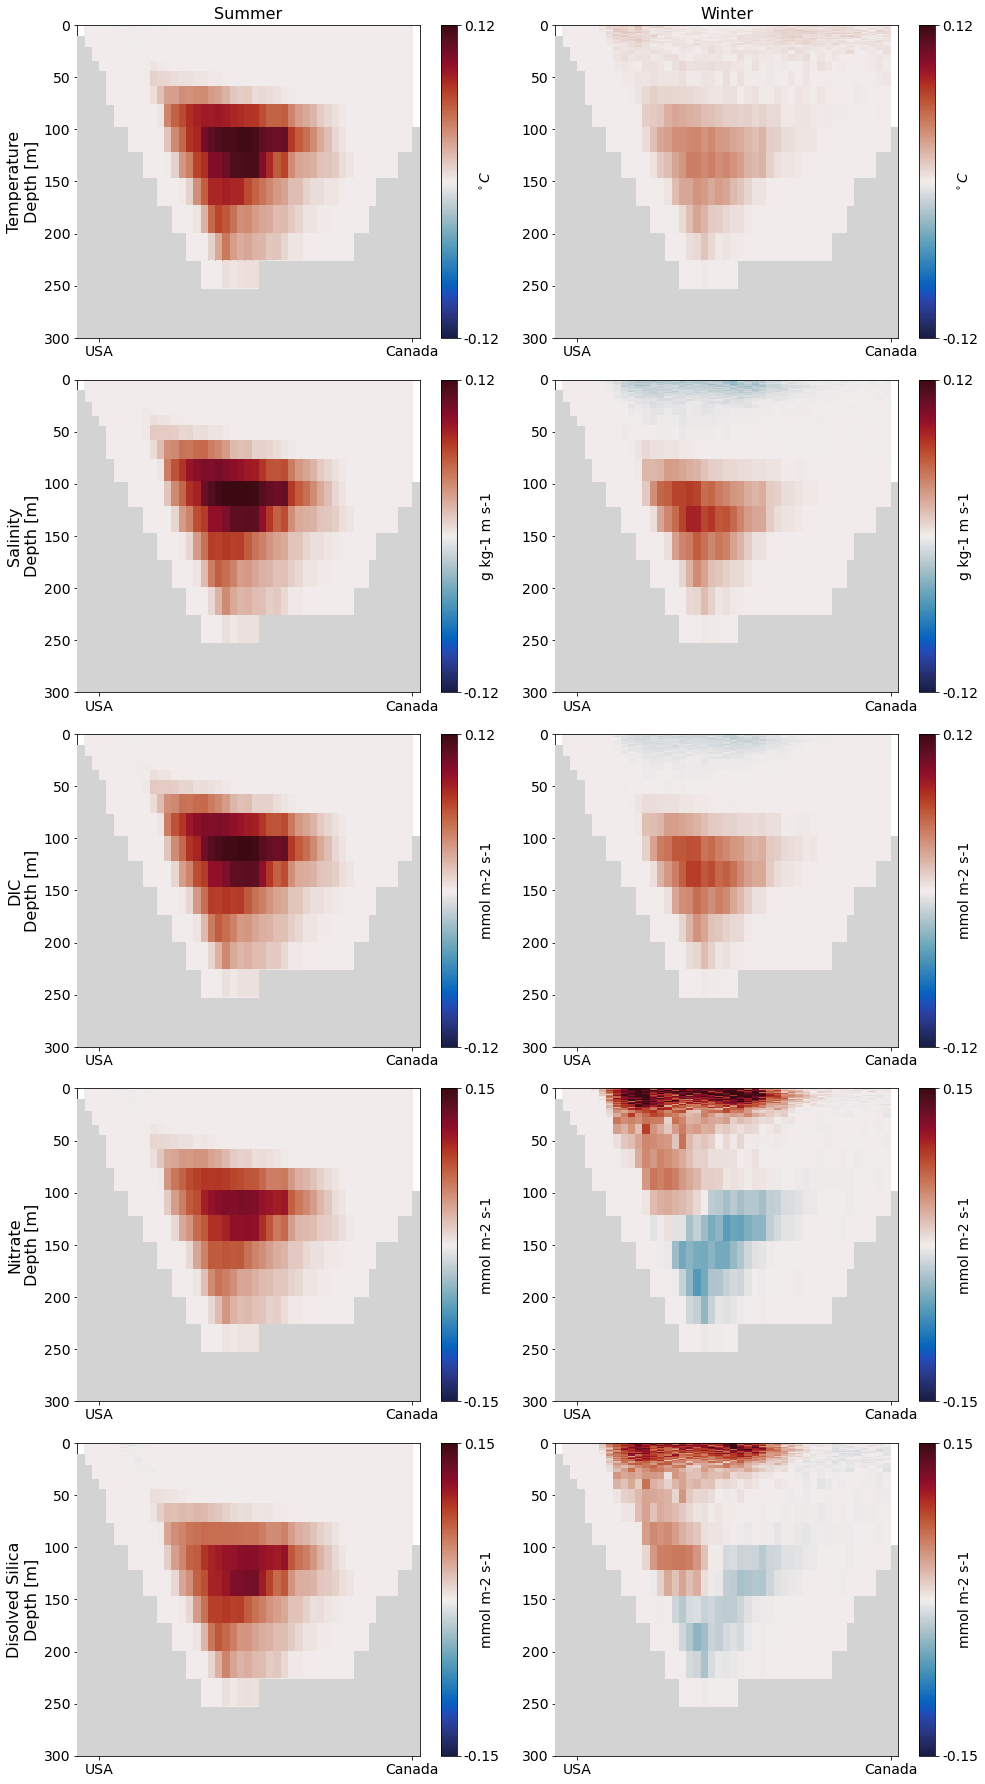

In [14]:
# now plt january and may for all four tracers
plt.rcParams['font.size'] = 14
str_mo = ['may', 'jan']
fig, ax = plt.subplots(5, 2, figsize = (14, 25))
for i in range(len(str_mo)):
    file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_1hr/forward_01'+str_mo[i]+'18/ariane_positions_quantitative.nc'
    mydata = xr.open_dataset(file)

    tracername = 'temp'
    temp[i] = JRTracerFluxCS_delta(tracername, 18, 63, 377, 300, ax[0,i], str_mo[i]+": "+tracername)
     
    file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Car_Sal/forward_01'+str_mo[i]+'18/ariane_positions_quantitative.nc'
    mydata = xr.open_dataset(file)

    tracername = 'salt'
    salt[i] = JRTracerFluxCS_delta(tracername, 18, 63, 377, 300, ax[1,i], str_mo[i]+": "+tracername)

    tracername = 'carbon'
    _ = JRTracerFluxCS_delta(tracername, 18, 63, 377, 300, ax[2,i], str_mo[i]+": "+tracername)

    file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Nit_Sil/forward_01'+str_mo[i]+'18/ariane_positions_quantitative.nc'
    mydata = xr.open_dataset(file)

    tracername = 'nitrate'
    _ = JRTracerFluxCS_delta(tracername, 18, 63, 377, 300, ax[3,i], str_mo[i]+": "+tracername)

    tracername = 'silicon'
    _ = JRTracerFluxCS_delta(tracername, 18, 63, 377, 300, ax[4,i], str_mo[i]+": "+tracername)      
    
ax[0,0].set_title('Summer', fontsize=16)
ax[0,1].set_title('Winter', fontsize=16)
ax[0,0].set_ylabel('Temperature\nDepth [m]', fontsize=16)
ax[1,0].set_ylabel('Salinity\nDepth [m]', fontsize=16)
ax[2,0].set_ylabel('DIC\nDepth [m]', fontsize=16)
ax[3,0].set_ylabel('Nitrate\nDepth [m]', fontsize=16)
ax[4,0].set_ylabel('Disolved Silica\nDepth [m]', fontsize=16)
    
# file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_1hr/forward_01jan18/ariane_positions_quantitative.nc'
# mydata = xr.open_dataset(file)
# _ = JRTracerFluxCS_delta_fullW('temp', 18, 63, 377, 300, ax[0,2], 'blyyp')
# file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Car_Sal/forward_01jan18/ariane_positions_quantitative.nc'
# mydata = xr.open_dataset(file)
# _ = JRTracerFluxCS_delta_fullW('salt', 18, 63, 377, 300, ax[1,2], 'bloop')
# _ = JRTracerFluxCS_delta_fullW('carbon', 18, 63, 377, 300, ax[2,2], 'bleep')
# file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Nit_Sil/forward_01jan18/ariane_positions_quantitative.nc'
# mydata = xr.open_dataset(file)
# _ = JRTracerFluxCS_delta_fullW('nitrate', 18, 63, 377, 300, ax[3,2], 'blaap')
# _ = JRTracerFluxCS_delta_fullW('silicon', 18, 63, 377, 300, ax[4,2], 'bliip')

plt.tight_layout()
plt.savefig("./figures/JDF_CS.pdf")

In [ ]:
def JRFluxSeason(lonW, lonE, figrid, maxdepth, ax, lons, transports, depths):
    igrid = figrid-1
    fmask = mymesh.fmask[0, :, igrid]
    tmask = mymesh.tmask[0]
    nav_lon = mymesh.nav_lon[igrid]
    
    t_lons = mymesh.glamt[0, igrid]
    m2lon = ((t_lons[lonE]-t_lons[lonW])/(mymesh.e1t[0, igrid, lonW:lonE].sum()))
    t_dist = t_lons/m2lon
    t_depths = mymesh.gdept_1d[0,:]
    
    xs, ys = np.meshgrid(np.array(t_dist), np.array(t_depths))
    
    dist = lons/m2lon
    
    vmax = .25/sum(transports)
    
    H, xedges, yedges = np.histogram2d(dist, depths*-1, bins=[np.array(t_dist[lonW-1:lonE]), t_depths],weights= transports, density= True)

#     maybe get rid of the lines? - the divide by numbers feel rather arbitrary but the best solution i can think of
#     not quatifying based on figs so i think fine
    h= H
    h[11,:] = H[11,:]/2.2
    h[19,:] = H[19,:]/2.3
    h[28,:] = H[28,:]/2
    h[36,:] = H[36,:]/2

    X, Y = np.meshgrid(xedges, yedges)
    im = ax.pcolormesh(X, Y, h.T, vmax = vmax, vmin = 0, cmap=cm.speed)
#     im = ax.pcolormesh(X, Y, H.T, vmax = vmax, vmin = 0, cmap=cm.speed)
    
    cb1 = fig.colorbar(im, ax=ax)
    cb1.set_ticks([0, vmax])
    cb1.set_ticklabels([0, np.round(((vmax * sum(transports)).values),2)]) 
    cb1.set_label('m s$^{-1}$', labelpad=-20)
    
    pc = draw_patches(fmask, lonW-2, lonE, np.array(t_dist), np.array(t_depths))
    ax.add_collection(pc)

    ax.invert_yaxis()
    ax.set_xticks([t_dist[lonW+1], t_dist[lonE-1]])
    ax.set_ylabel('Depth [m]')
    ax.set_xticklabels(np.round([t_lons[lonW+1], t_lons[lonE-1]],2))
    ax.set_xlim((t_dist[lonW-2], t_dist[lonE]))
    ax.set_ylim((maxdepth, 0))
#     ax.set_title(str(title))

In [6]:
def JRTracer_delta(tracername, lonW, lonE, figrid, maxdepth, ax, title):
    igrid = figrid-1
    fmask = mymesh.fmask[0, :, igrid]
    tmask = mymesh.tmask[0]
    nav_lon = mymesh.nav_lon[igrid]
    time = 720
    
    lons = mydata.init_lon[(mydata.final_section != 0)]
    lats = mydata.init_lat[(mydata.final_section != 0)]
    
    t_lons = mymesh.glamt[0, igrid]
    m2lon = ((t_lons[lonE]-t_lons[lonW])/(mymesh.e1t[0, igrid, lonW:lonE].sum()))
    t_dist = t_lons/m2lon
    t_depths = mymesh.gdept_1d[0,:]
    
    xs, ys = np.meshgrid(np.array(t_dist), np.array(t_depths))
    
    dist = lons/m2lon
    depths = depthf(mydata.init_z[(mydata.final_section != 0)]-1.)[0]
    transports = mydata.init_transp[(mydata.final_section != 0)]/time
    
    #ambient concentrations from "AmbientTracerConc.ipynb"
    amSa = 31.417757428541577 #g/kg
    amT = 9.005697383879731
    
    if tracername == 'salt':
        tracer = mydata.init_salt[(mydata.final_section != 0)]
        t_max = 35
        t_min = 28
        units = 'g kg-1 m s-1'
        cmap = cm.haline
    elif tracername == 'temp':
        tracer = mydata.init_temp[(mydata.final_section != 0)]
        t_max = 11
        t_min = 6
        units = '$^\circ C$'
        cmap = cm.thermal
    elif tracername == 'density':
        tracer = mydata.init_dens[(mydata.final_section != 0)]
        t_max = 28
        t_min = 22
        units = '$kg m^{-3}$'
        cmap = cm.dense
    else:
        print('incorrect tracer name, options are salt, temp')

    H = binned_statistic_2d(dist, depths, tracer, statistic=np.mean, bins=[np.array(t_dist[lonW-1:lonE]), t_depths])
    _, xedges, yedges = np.histogram2d(dist, depths, bins = [np.array(t_dist[lonW-1:lonE]), t_depths])
    h = H.statistic.T

    X, Y = np.meshgrid(xedges, yedges)
    im = ax.pcolormesh(X, Y, h, vmax = t_max, vmin = t_min, cmap=cmap)
    cb1 = fig.colorbar(im, ax=ax)
    cb1.set_ticks([t_min, t_max])
    cb1.set_ticklabels([t_min, t_max]) 
    cb1.set_label(units, labelpad=-20)
    
    CS = ax.contour(X[:-1,:-1],Y[:-1,:-1], h, np.arange(t_min,t_max, 0.75), colors='b', zorder = 2)
    ax.clabel(CS, inline=1, fontsize=7)
    
    pc = draw_patches(fmask, lonW-2, lonE, np.array(t_dist), np.array(t_depths))
    ax.add_collection(pc)

    ax.set_ylabel('Depth [m]')
    ax.invert_yaxis()
    ax.set_xticks([t_dist[lonW+1], t_dist[lonE-1]])
    ax.set_xticklabels(np.round([t_lons[lonW+1], t_lons[lonE-1]],2))
    ax.set_xlim((t_dist[lonW-2], t_dist[lonE]))
    ax.set_ylim((maxdepth, 0))
    mydata.close()

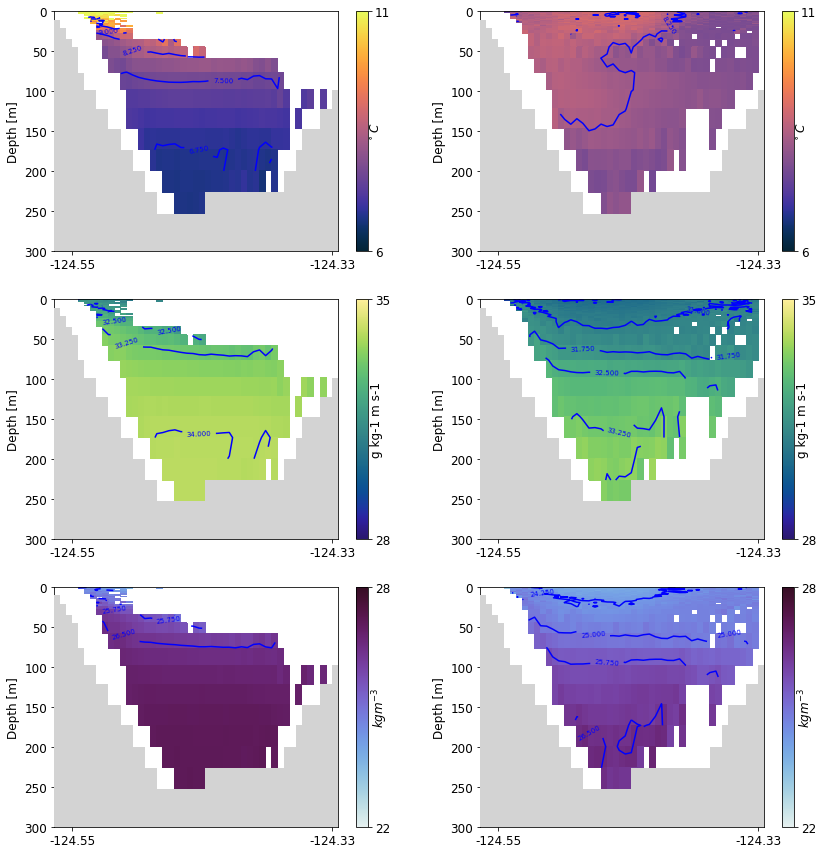

In [144]:
# now plt january and may for all four tracers
str_mo = ['may', 'jan']
fig, ax = plt.subplots(3, 2, figsize = (14, 15))

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_1hr/forward_01may18/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)

tracername = 'temp'
JRTracer_delta(tracername, 18, 63, 377, 300, ax[0,0], "may: "+tracername)

tracername = 'salt'
JRTracer_delta(tracername, 18, 63, 377, 300, ax[1,0], "may: "+tracername)

tracername = 'density'
JRTracer_delta(tracername, 18, 63, 377, 300, ax[2,0], "may: "+tracername)

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_1hr/forward_01jan18/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)

tracername = 'temp'
JRTracer_delta(tracername, 18, 63, 377, 300, ax[0,1], "jan: "+tracername)

tracername = 'salt'
JRTracer_delta(tracername, 18, 63, 377, 300, ax[1,1], "jan: "+tracername)

tracername = 'density'
JRTracer_delta(tracername, 18, 63, 377, 300, ax[2,1], "jan: "+tracername)

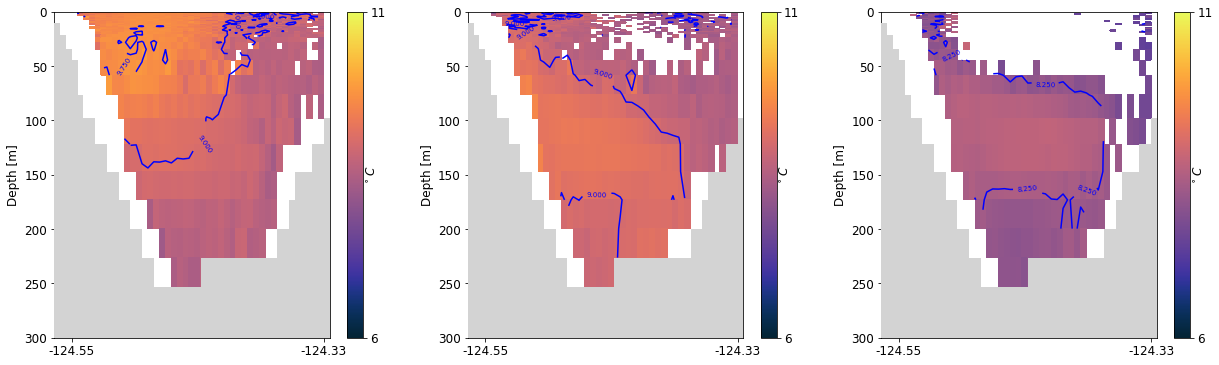

In [39]:
# lets see if those months with high intermediate inflow also look transient like we'd expect them to
fig, ax = plt.subplots(1,3,figsize=(21,6))

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_1hr/forward_01dec18/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
JRTracer_delta('temp', 18, 63, 377, 300, ax[0], "December 2018")

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_1hr/forward_01jan19/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
JRTracer_delta('temp', 18, 63, 377, 300, ax[1], "January 2019")

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_1hr/forward_01feb19/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
JRTracer_delta('temp', 18, 63, 377, 300, ax[2], "February 2019")

#### not a consistent shape like we'd hope! The Intermediate >8.25 degree flow does not only come in during intermediate but is present the whole winter in 2018/19, looks like its jsut the main centre of the estuarine flow. Use  higher temp for funky stuff? argh
#### could still be interesting from a water mass coming in perspective but not an indicator of transient flow